# Compartment SB2 - Jupyter Script
Test Script to explain each function coded in our files

### Imports used

In [1]:
import h5py
import sys
import numpy as np
from scipy.spatial import ConvexHull
from scipy import sparse
from sklearn.manifold import MDS
from hmmlearn import hmm

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import HiCtoolbox #functions in our file HiCtoolbox.py

2021-12-28 02:03:58.247407: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


### Variables to change
To change the gene or the chromosome to work on

In [2]:
nb = '22'
gene = 'GM12878'
filter_ratio = 1

### Global variables

In [3]:
res = 100000 #Resolution
nb_max_epi = 15 #Epi states go from 0 to 15
alpha = 0.227 #Alpha
selected_mark = 1 #Index of the selected mark
hic_filename='chr'+nb+'_100kb.RAWobserved' #HiC File
chr_nb = 'chr'+nb
epig_filename='E116_15_coreMarks_dense' #Epigenic Marks File
density_filename = 'chr'+nb+'.hdf5'
path_to_leo_data = '../HiCdataLeopold/'+gene+'/100kb/chr'+nb+'_compartiment.txt'

centro_pos = pd.read_csv("centromericpos_hg19.txt", sep="\t", header=None)
centro_start = int(centro_pos.loc[centro_pos[0] == chr_nb][1])/100000
centro_end = int(centro_pos.loc[centro_pos[0] == chr_nb][2])/100000

expr_repr_scores_file = pd.read_csv("expr_repr_scores.csv", sep="\t", header=None)
expr_scores = expr_repr_scores_file[2].to_numpy()
repr_scores = expr_repr_scores_file[4].to_numpy()
expr_repr_scores = expr_scores - repr_scores

validation_data = pd.read_table(path_to_leo_data)
data = validation_data.to_numpy()
data[data == 0.] = 2.
data[data == -1.] = 0.
data[data == 2.] = -1.
data = -data
val_data = data

### Density of the chromosome

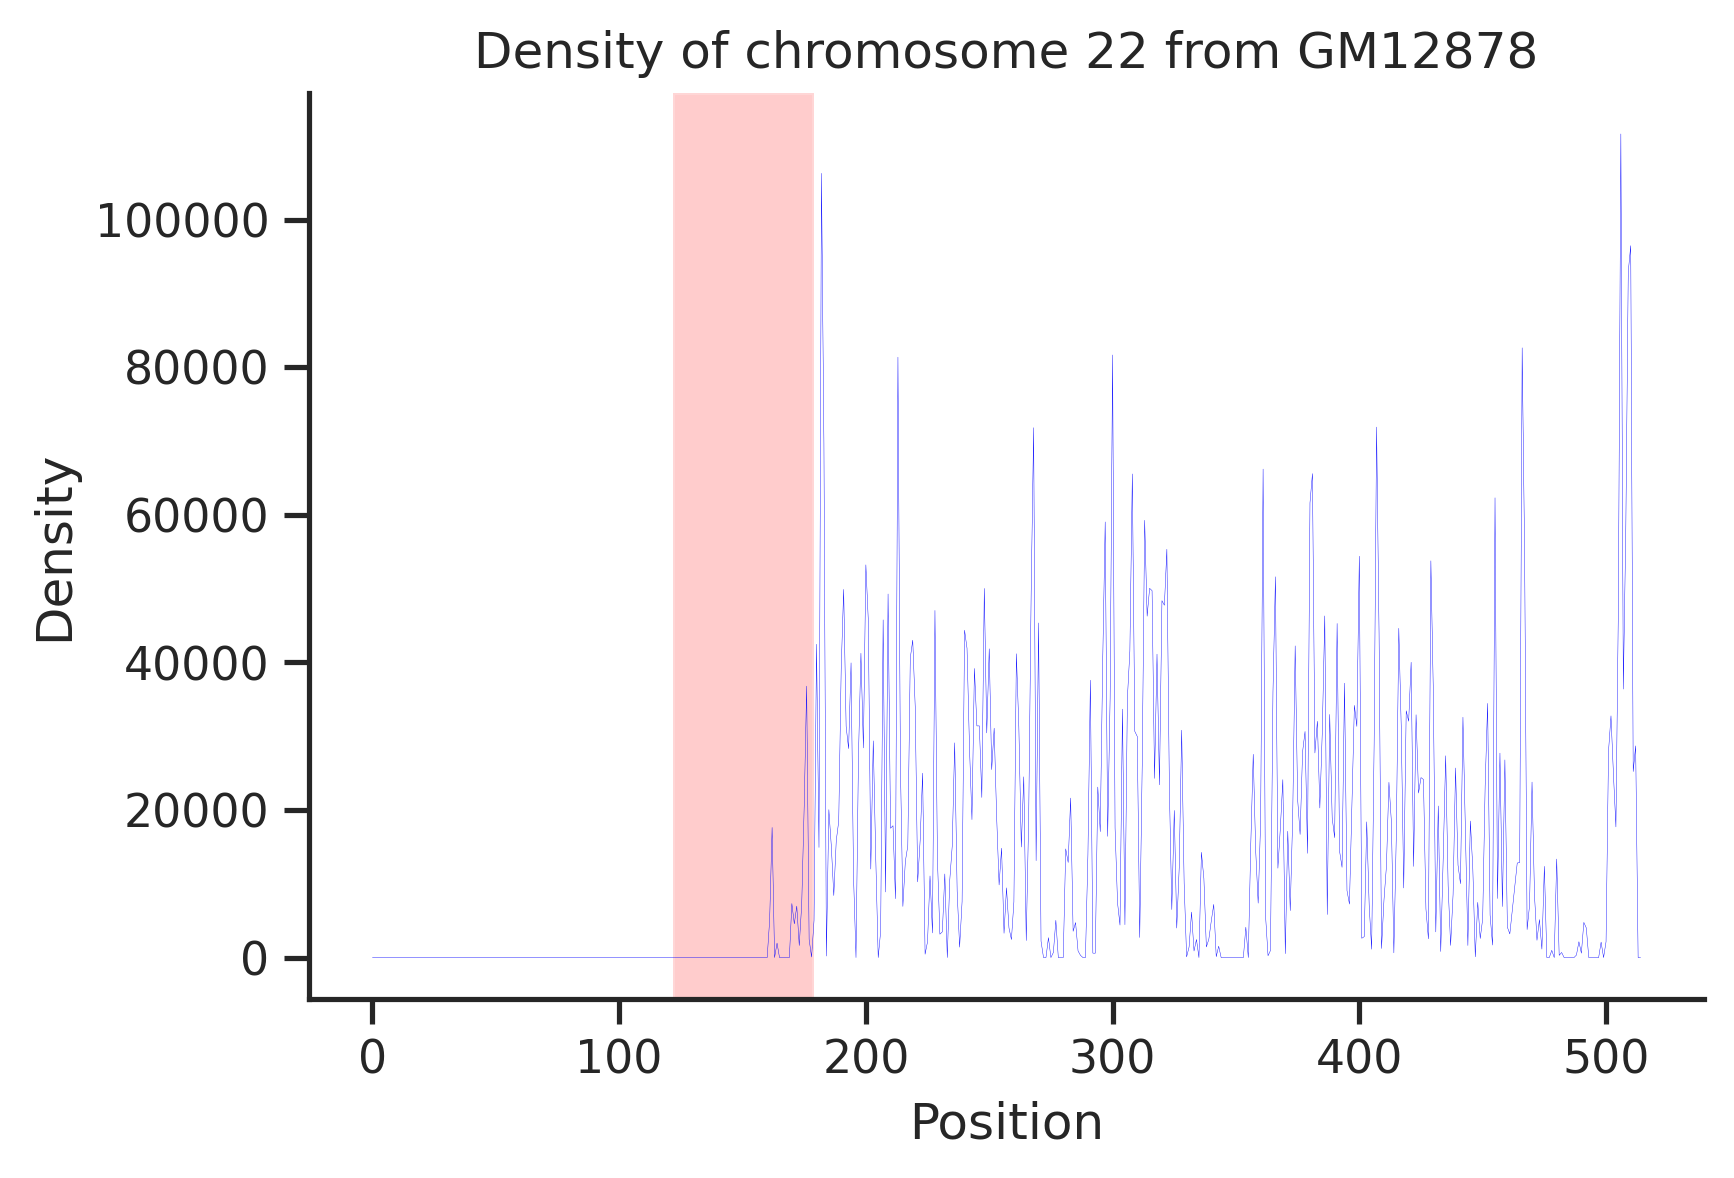

<Figure size 432x288 with 0 Axes>

In [4]:
density_data = h5py.File(density_filename, 'r')
data = density_data['data'][:]
density = data
title = 'Density of chromosome '+nb+' from '+gene
HiCtoolbox.plotter(data, title, 'Density', jupyter=True, centro_start=centro_start, centro_end=centro_end)

### Building the matrix

In [5]:
matrix = HiCtoolbox.buildMatrix(hic_filename, printer=False)
binned_map = HiCtoolbox.bin2d(matrix, res, res, printer=False)
old_shape = np.shape(matrix)[0]
new_shape = np.shape(binned_map)

### Building the colors

In [6]:
color_vec = HiCtoolbox.buildColors(epig_filename, chr_nb, old_shape, printer=False)
color_bins = HiCtoolbox.bin2d(color_vec, res, 1, printer=False)
color_bins = color_bins/np.amax(color_bins)

### Plot the matrix before filtering

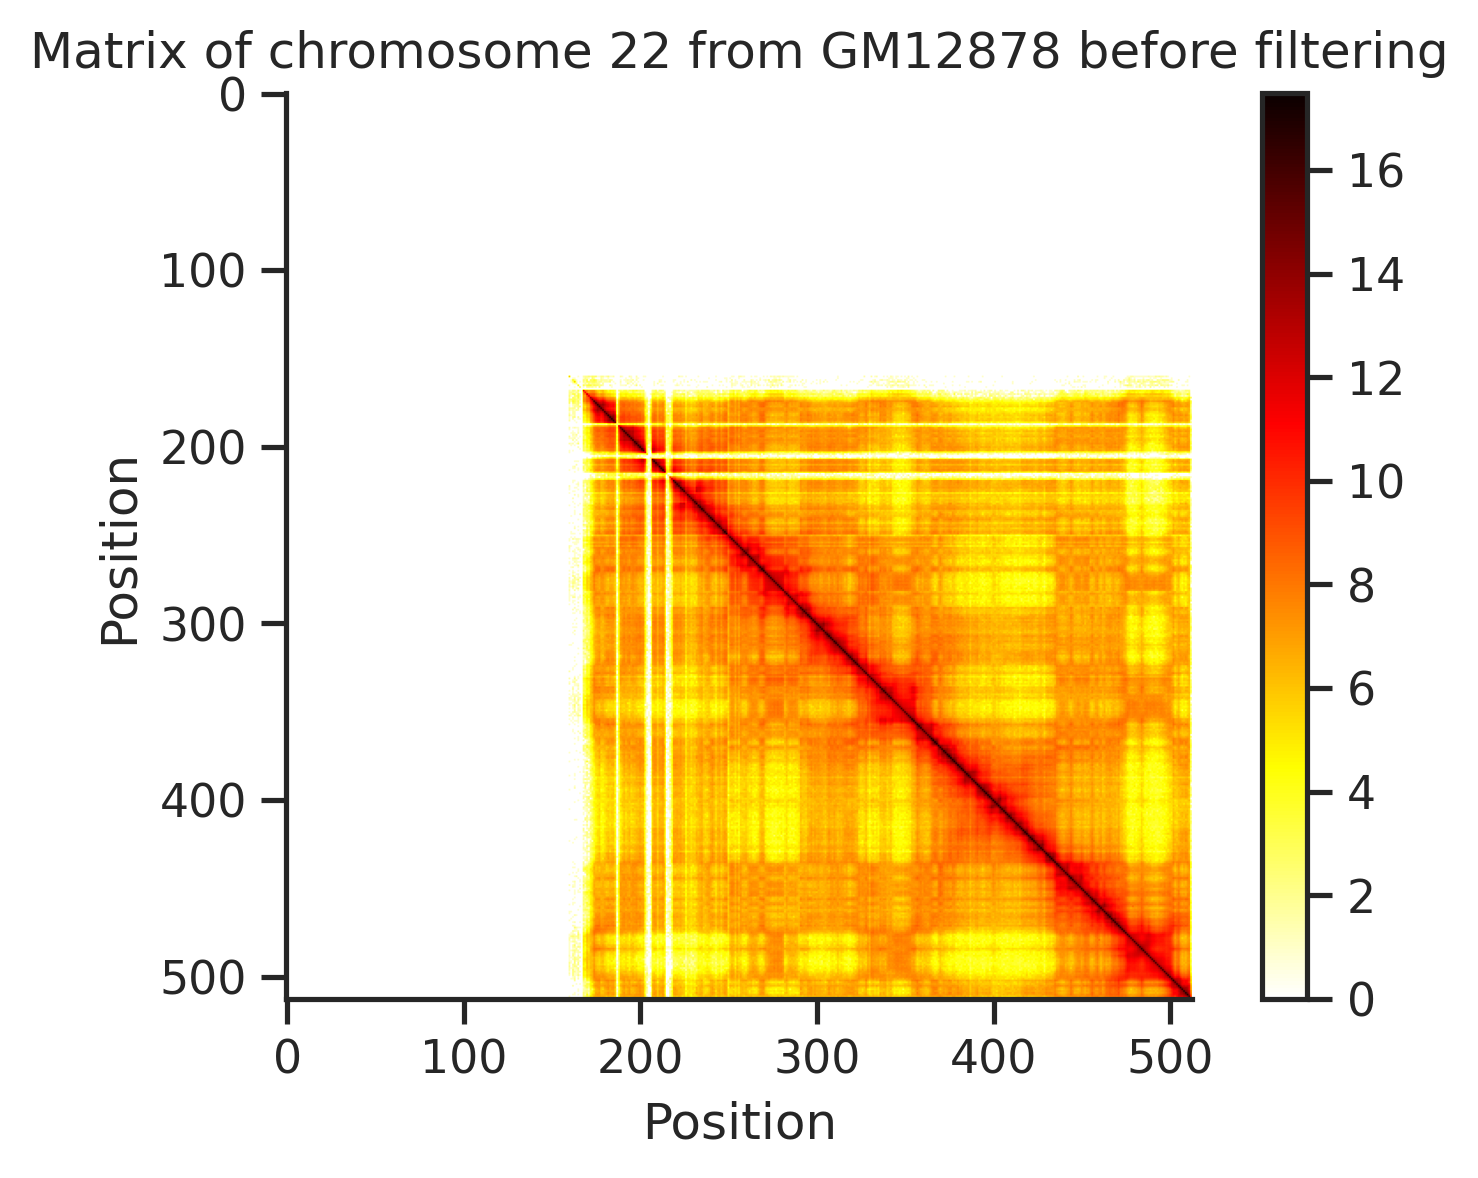

<Figure size 432x288 with 0 Axes>

In [7]:
data = np.log2(1 + sparse.csr_matrix.toarray(binned_map))
title = 'Matrix of chromosome '+nb+' from '+gene+' before filtering'
HiCtoolbox.plotter(data, title ,'Matrix', jupyter=True)

### Plot the matrix after filtering

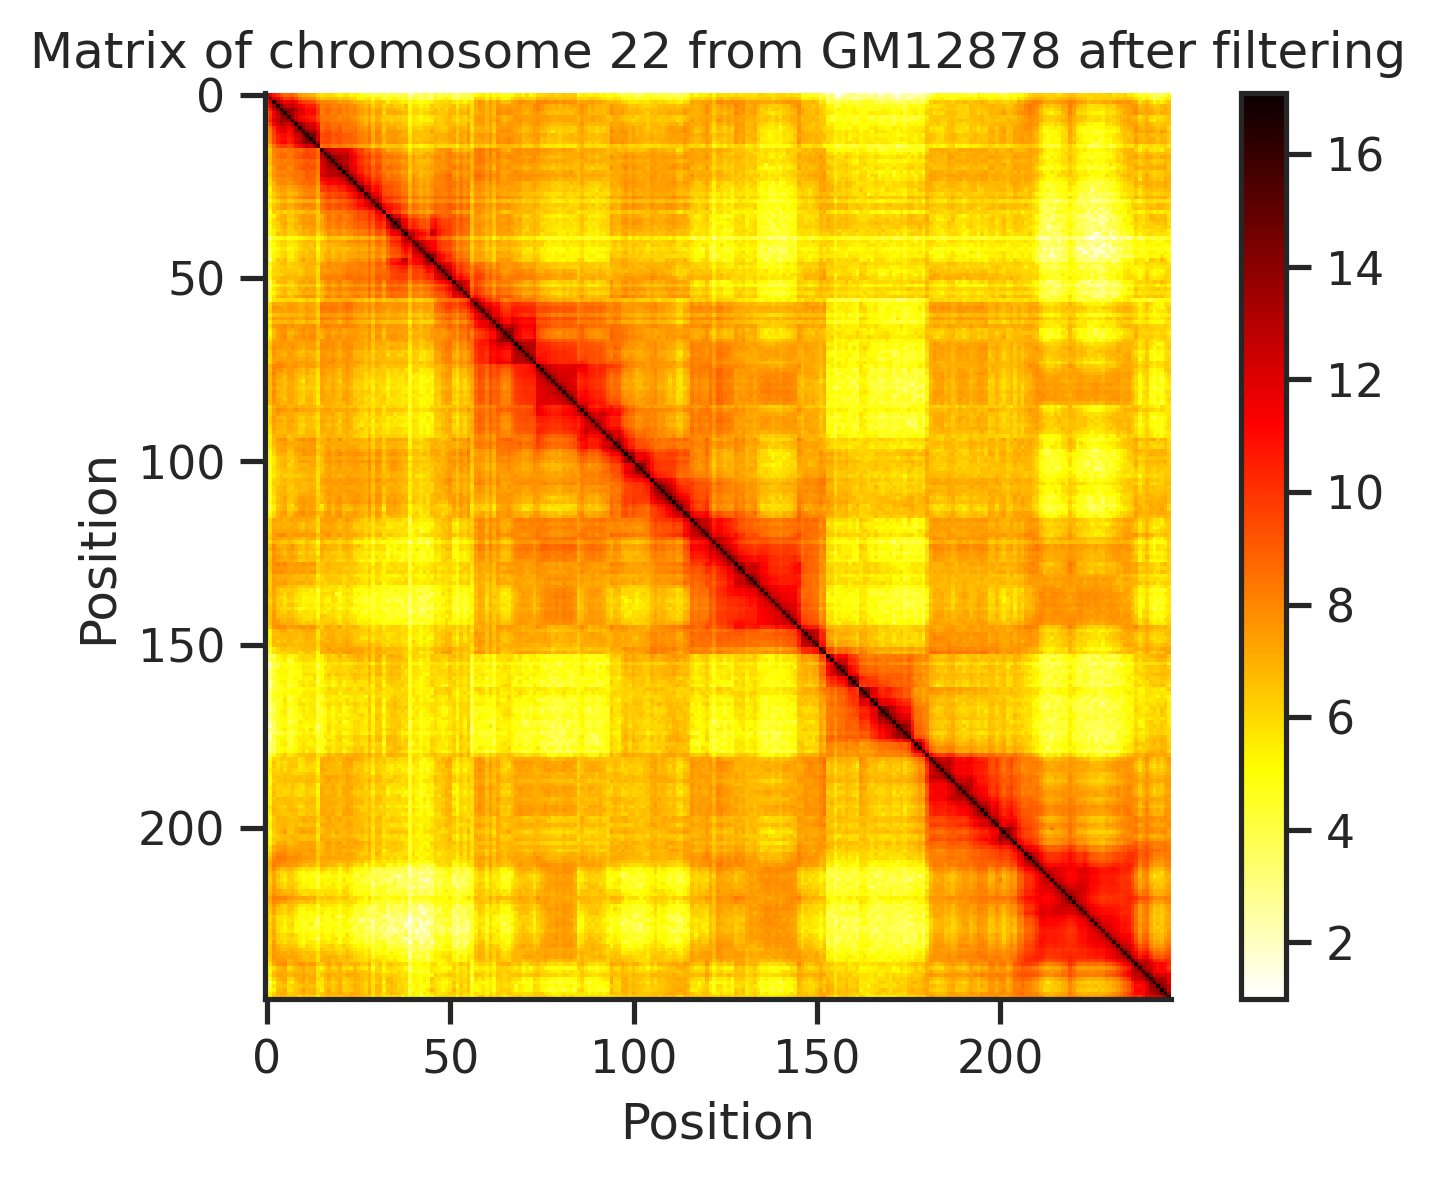

<Figure size 432x288 with 0 Axes>

In [8]:
filtered_map, bin_saved = HiCtoolbox.filtering(binned_map, filter_ratio, printer=False)
data = np.log2(1+sparse.csr_matrix.toarray(filtered_map))
title = 'Matrix of chromosome '+nb+' from '+gene+' after filtering'
HiCtoolbox.plotter(data, title, 'Matrix', jupyter=True)

### Update the resolution of the colors

In [9]:
new_color = color_bins[bin_saved[1]]
new_color = new_color[:, selected_mark]
new_color = np.float64(new_color.todense())

### Plot the SCN matrix

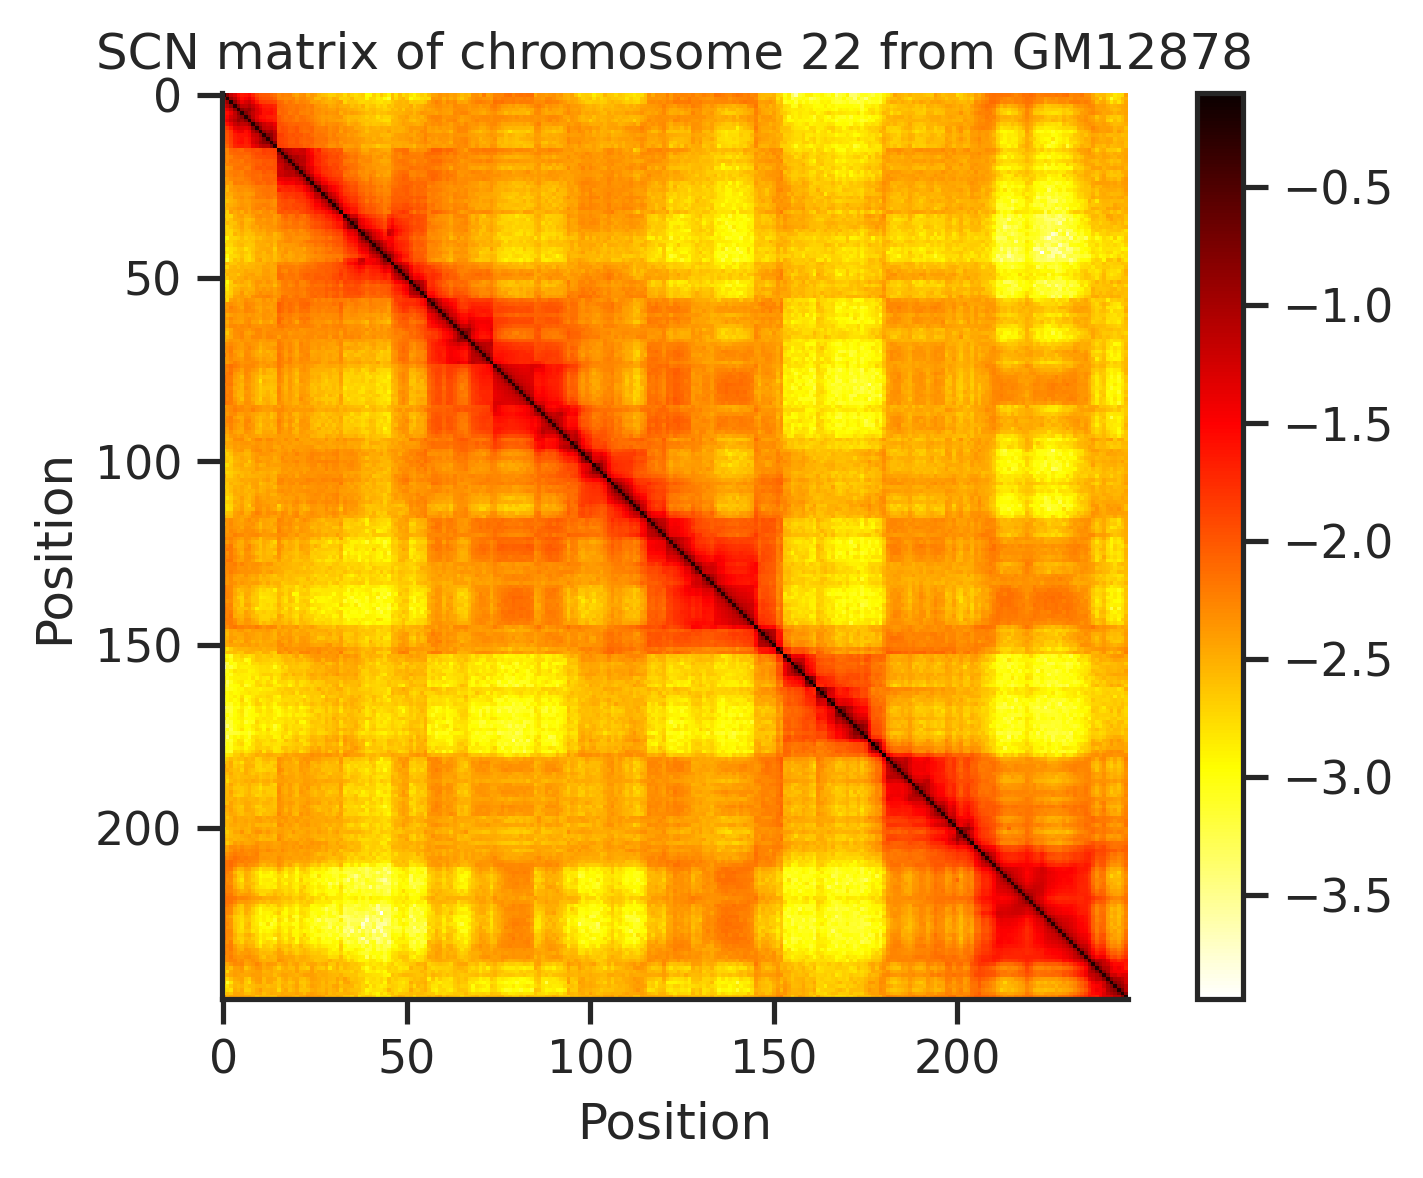

<Figure size 432x288 with 0 Axes>

In [10]:
scn_map = HiCtoolbox.SCN(filtered_map.copy(), printer=False)
scn_map = np.asarray(scn_map)**alpha
data = np.log2(scn_map)
title = 'SCN matrix of chromosome '+nb+' from '+gene
HiCtoolbox.plotter(data, title, 'Matrix', jupyter=True)

### Plot the distance matrix

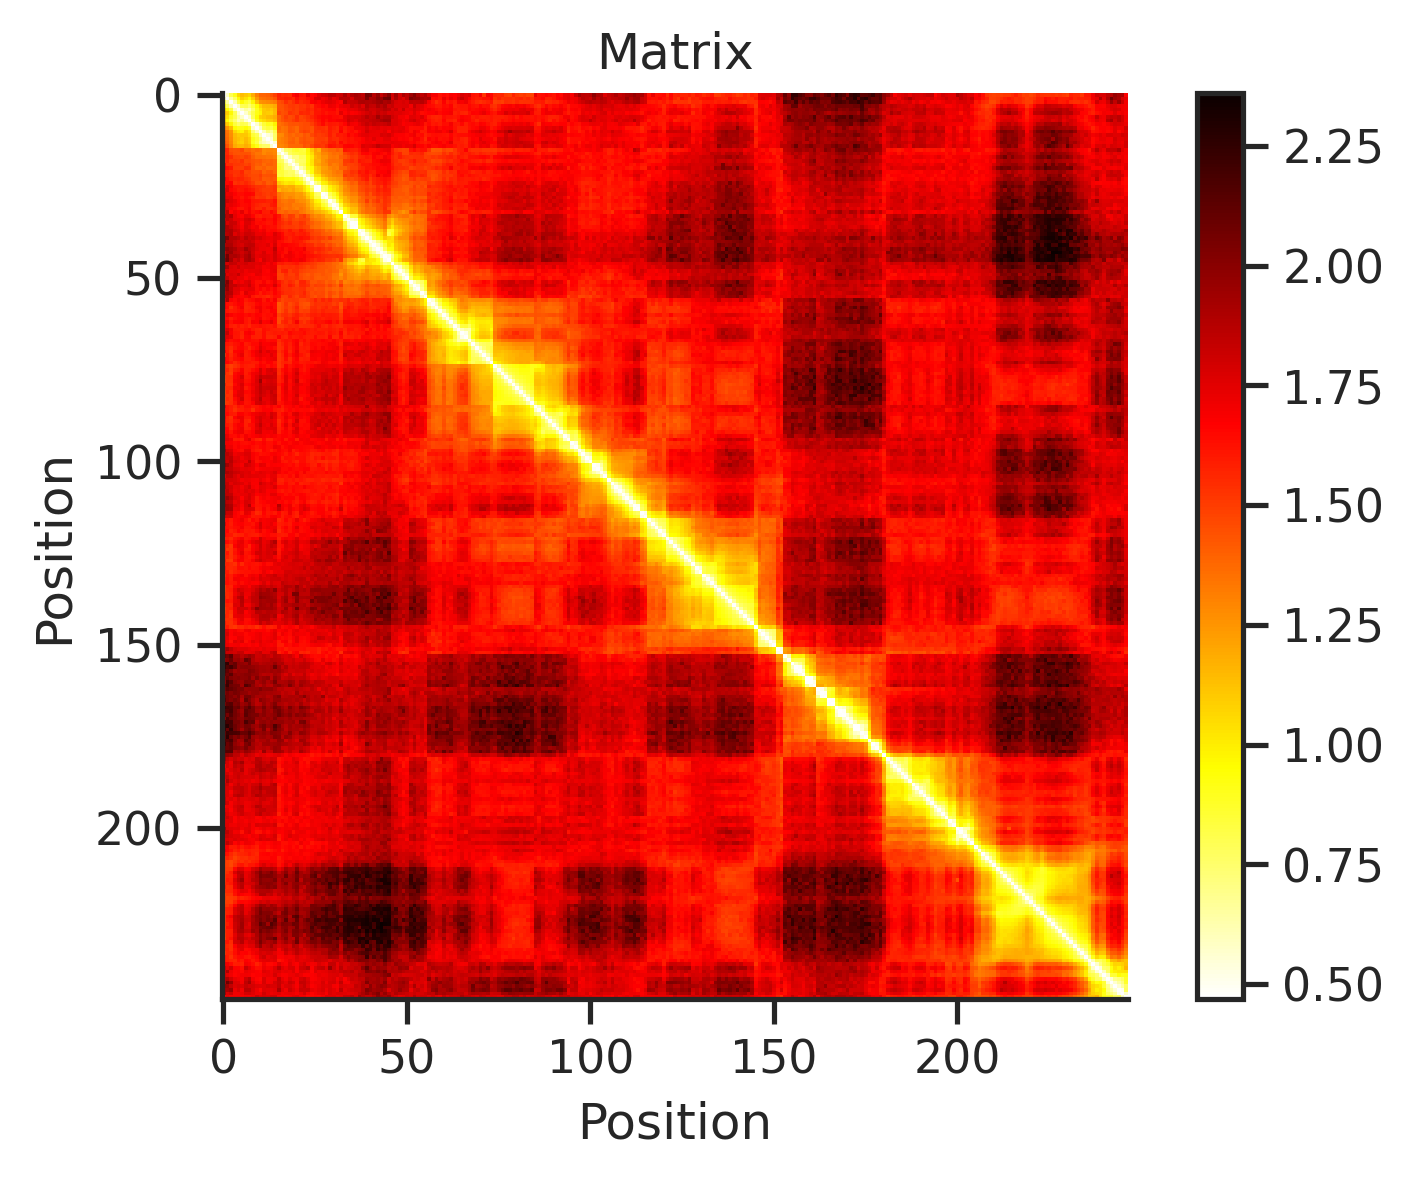

<Figure size 432x288 with 0 Axes>

In [11]:
dist_matrix = HiCtoolbox.fastFloyd(1/scn_map, printer=False)
dist_matrix = dist_matrix-np.diag(np.diag(dist_matrix))
dist_matrix = (dist_matrix+np.transpose(dist_matrix))/2
data = np.log(dist_matrix)
title = 'Distance matrix of chromosome '+nb+' from '+gene
HiCtoolbox.plotter(data, 'Matrix', jupyter=True)

### Plot the O/E matrix

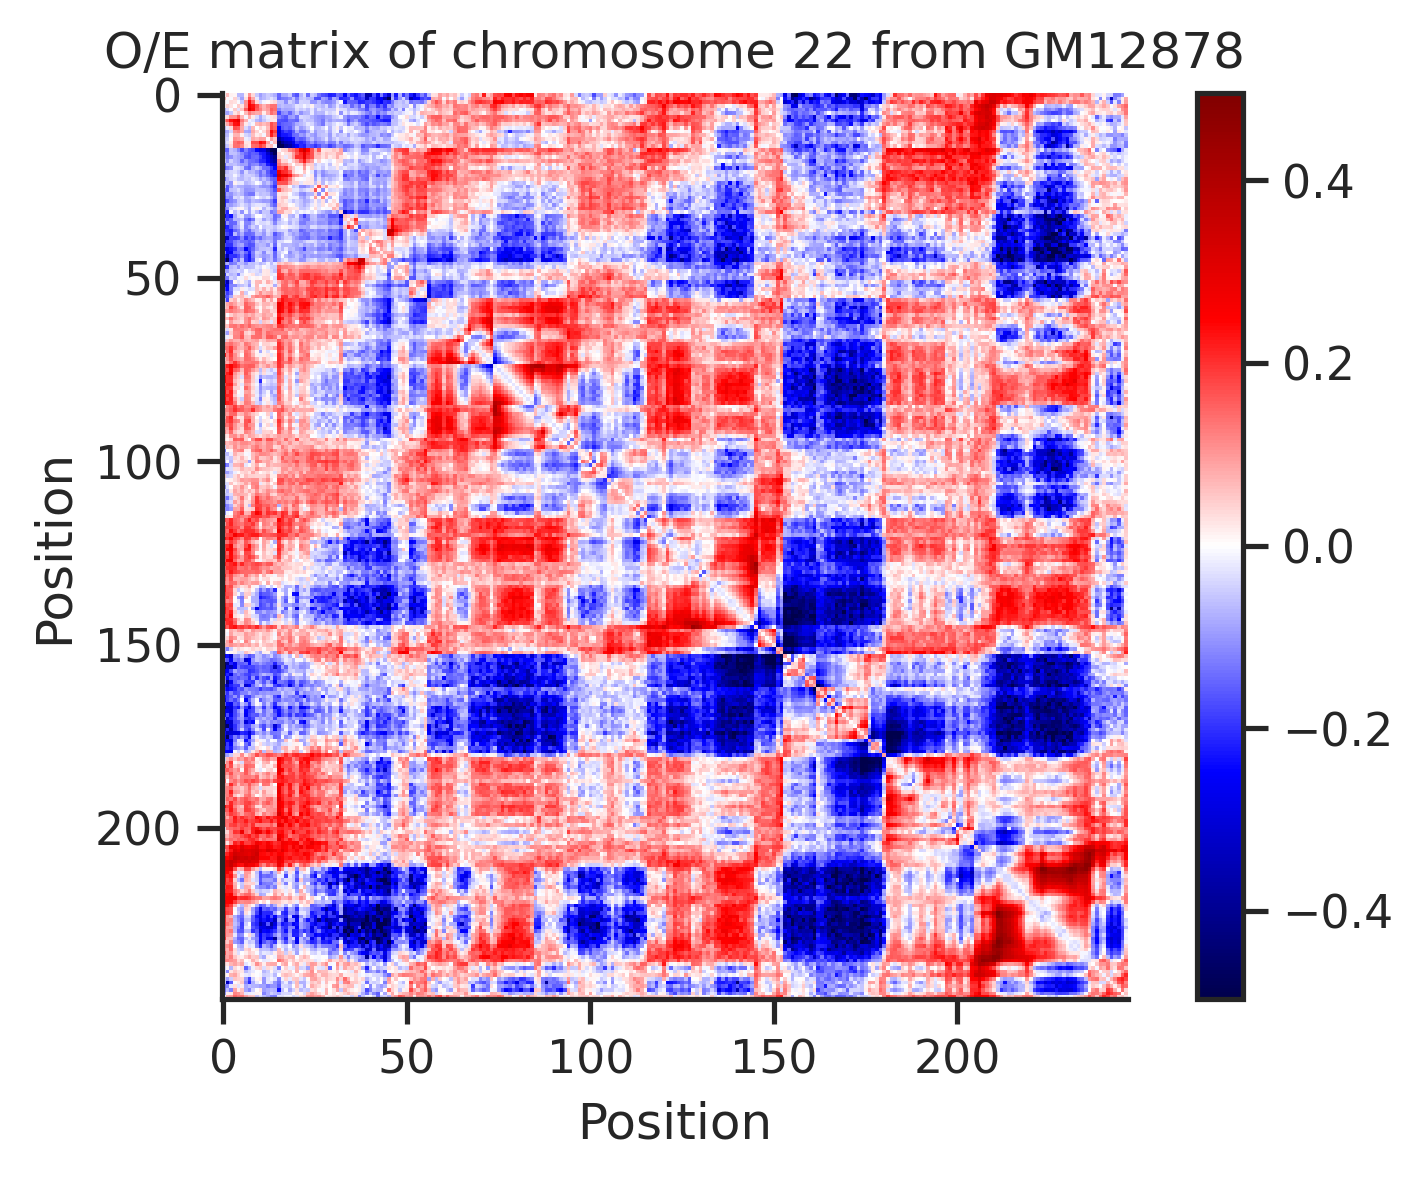

<Figure size 432x288 with 0 Axes>

In [12]:
contact_map = HiCtoolbox.OE(scn_map, printer=False)
data = np.log(contact_map)
vmin = -np.amax(data)
vmax = np.amax(data)
title = 'O/E matrix of chromosome '+nb+' from '+gene
HiCtoolbox.plotter(data, title, 'Matrix', cmap='seismic', vmin=vmin, vmax=vmax, jupyter=True)

### Plot the correlation matrix

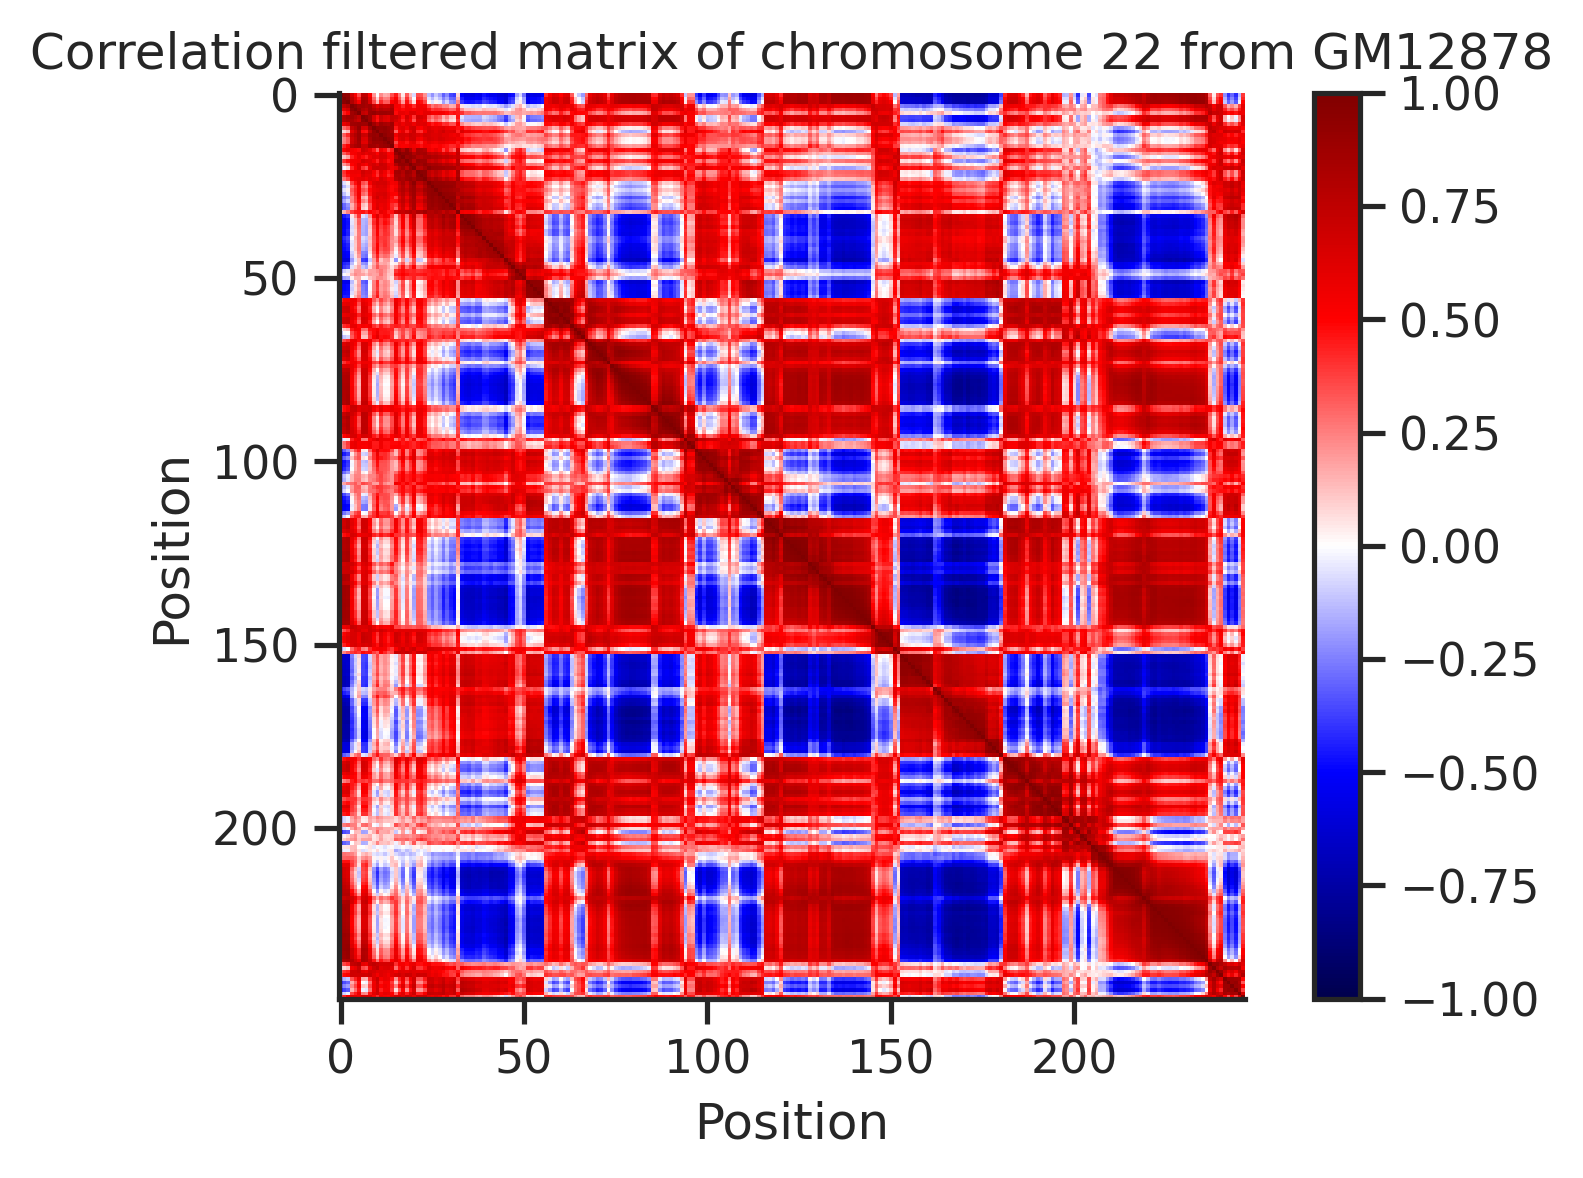

<Figure size 432x288 with 0 Axes>

In [13]:
corr_map = HiCtoolbox.Corr(contact_map, printer=False)
data = corr_map
vmin = -np.amax(data)
vmax = np.amax(data)
title = 'Correlation filtered matrix of chromosome '+nb+' from '+gene
HiCtoolbox.plotter(data, title, 'Matrix', cmap="seismic", vmin=vmin, vmax=vmax, jupyter=True)

### Plot the correlation matrix unfiltered

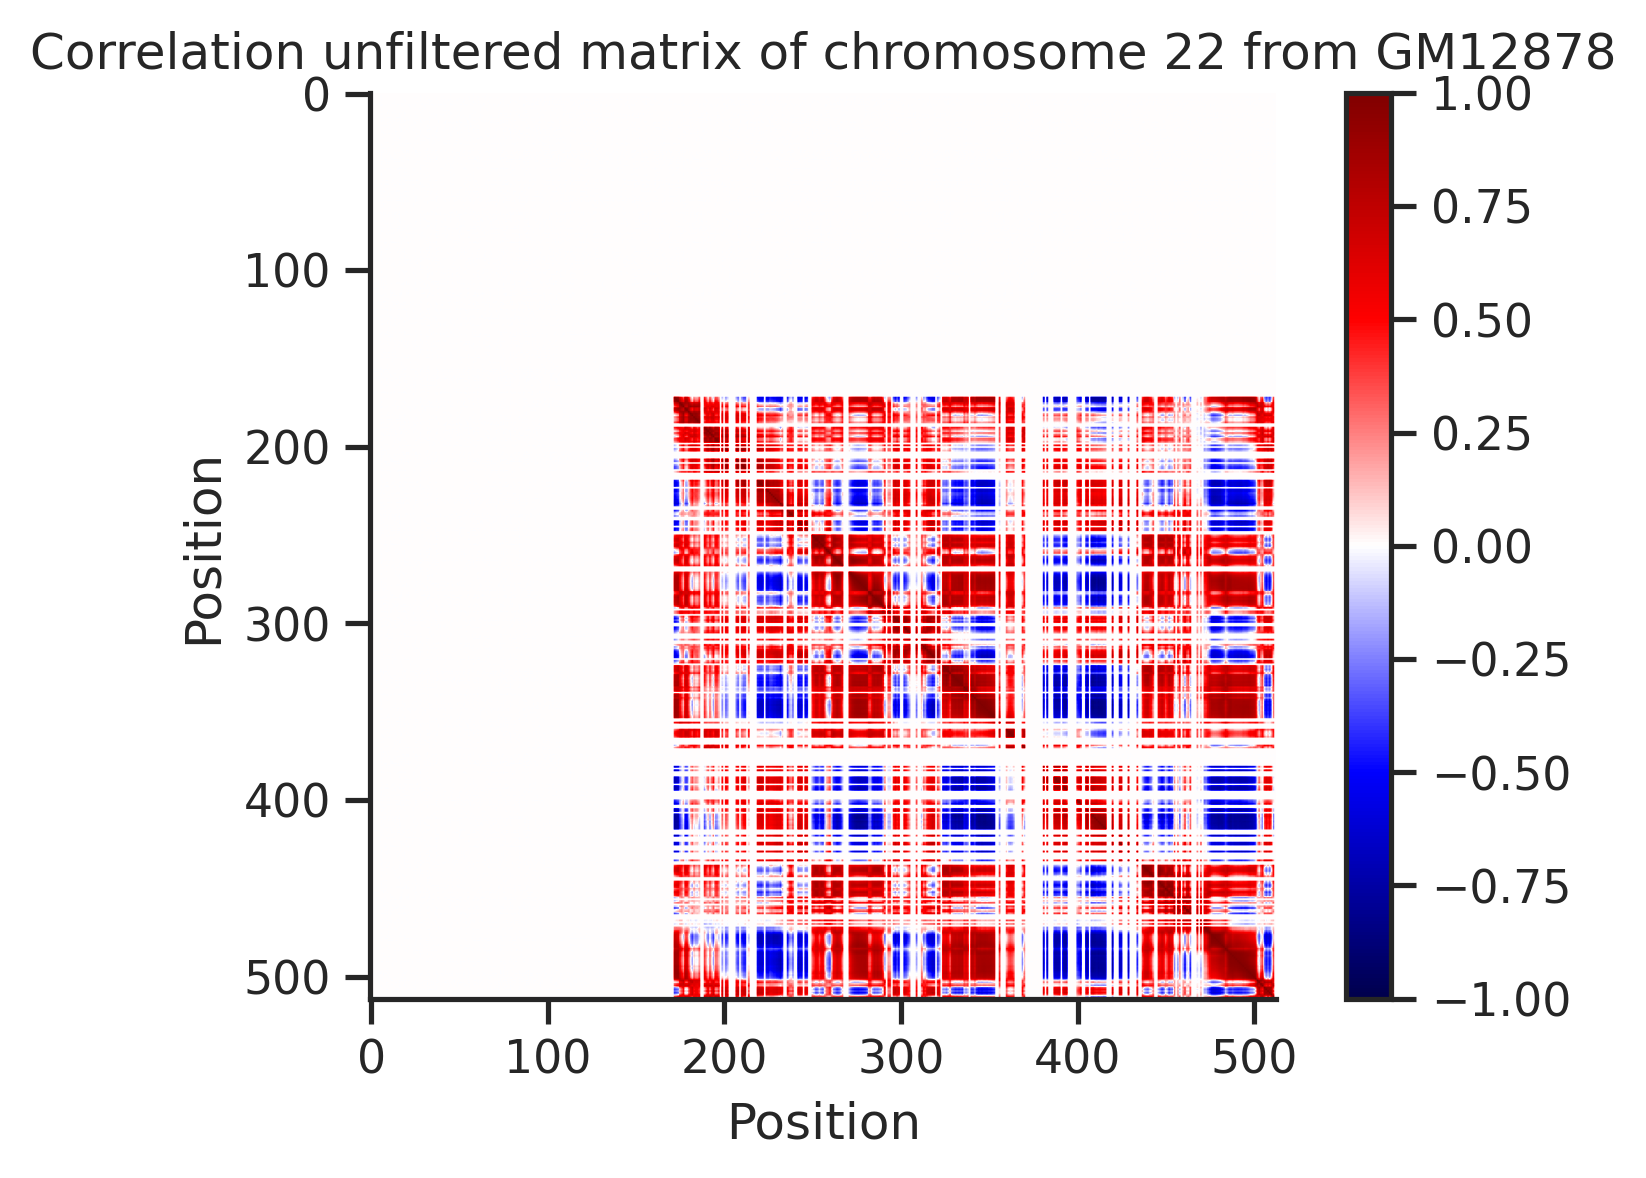

<Figure size 432x288 with 0 Axes>

In [14]:
unfiltered_corr_map = HiCtoolbox.unfiltering(bin_saved, corr_map, new_shape, printer=False)
data = unfiltered_corr_map
corr = data
title = 'Correlation unfiltered matrix of chromosome '+nb+' from '+gene
HiCtoolbox.plotter(data, title, 'Matrix', cmap="seismic", vmin=vmin, vmax=vmax, jupyter=True)

### Plot the AB compartments

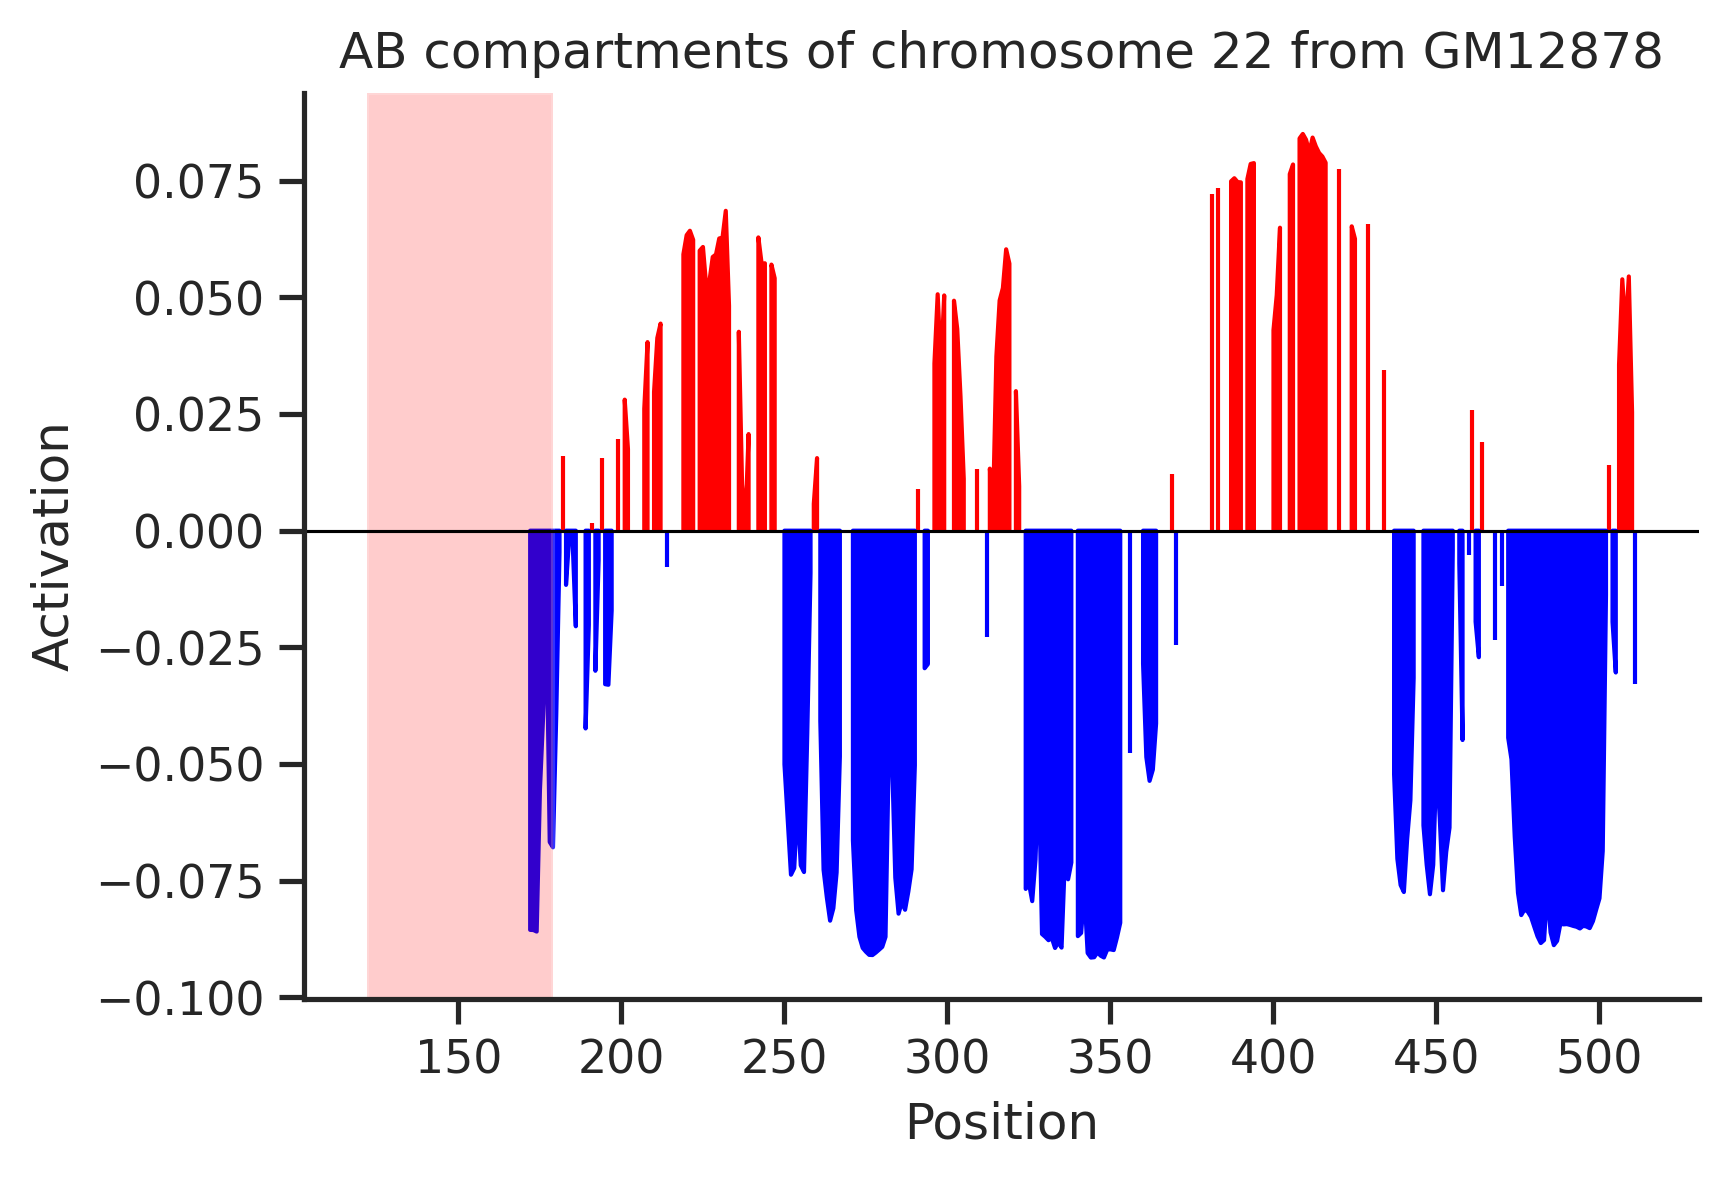

<Figure size 432x288 with 0 Axes>

In [16]:
data = HiCtoolbox.SVD(unfiltered_corr_map)
AB = []
for i in range(len(data)):
    if i>0:
        AB.append(1)
    elif i<0:
        AB.append(-1)
    else:
        AB.append(0)
title = 'AB compartments of chromosome '+nb+' from '+gene
HiCtoolbox.plotter(data, title, 'AB', jupyter=True, centro_start=centro_start, centro_end=centro_end)

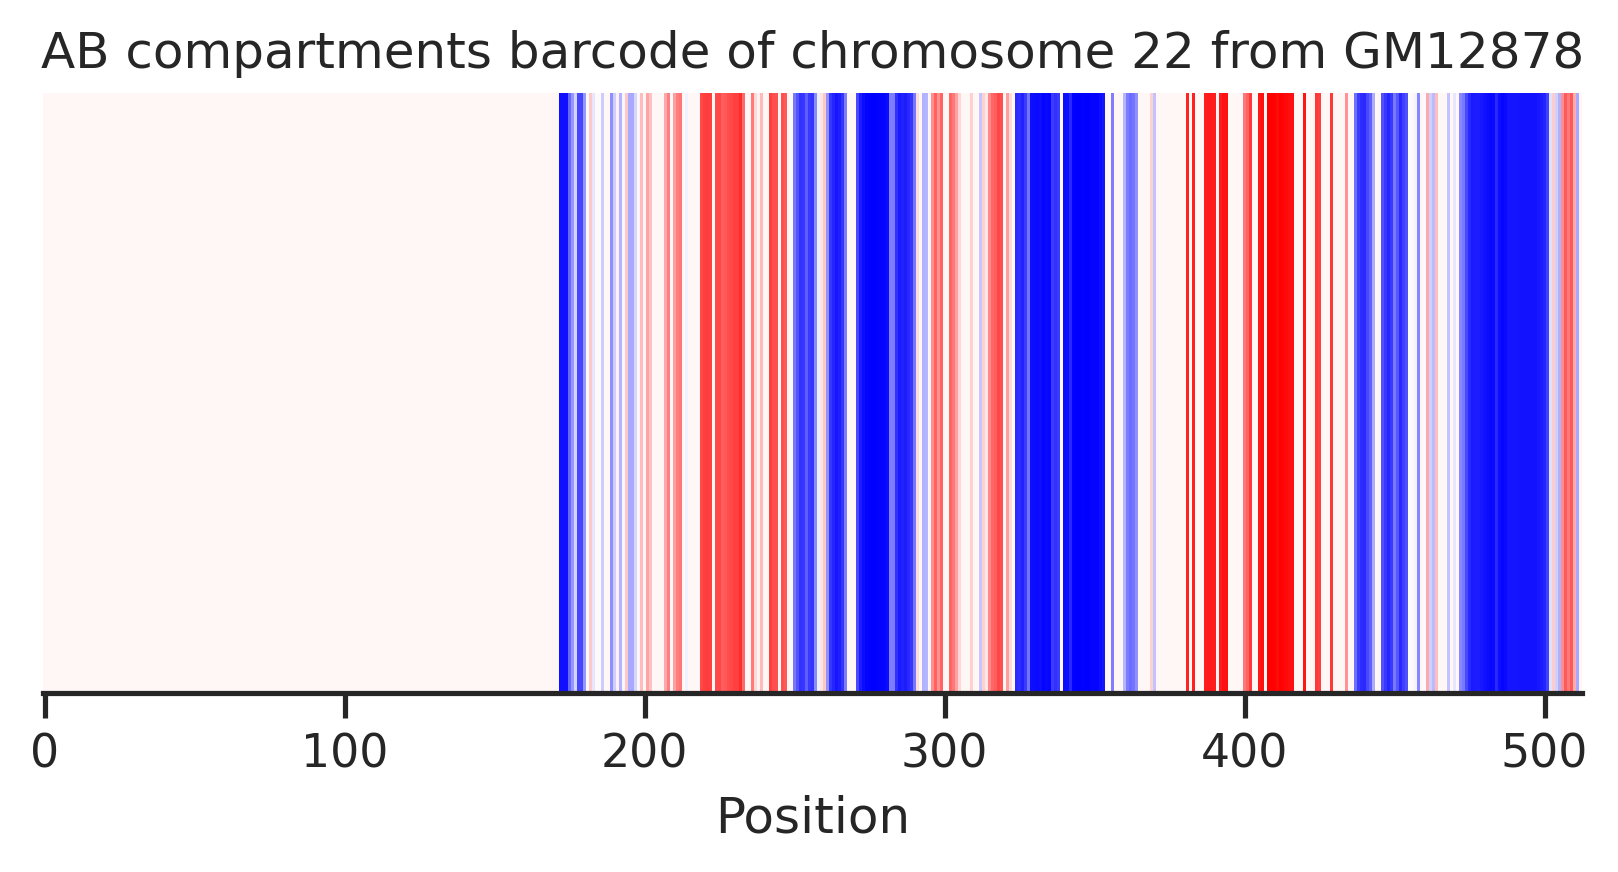

<Figure size 432x288 with 0 Axes>

In [17]:
title = 'AB compartments barcode of chromosome '+nb+' from '+gene
HiCtoolbox.plotter(data, title, 'Barcode', jupyter=True)

### Load the MDS

In [18]:
XYZ, E = HiCtoolbox.sammon(dist_matrix, 3, display=0) #with the one from tom j pollard
hull = ConvexHull(XYZ)
scale = 100/hull.area**(1/3)
XYZ = XYZ*scale

## Method 1

### Gaussian HMM with eigenvector from correlation matrix

In [19]:
vector = HiCtoolbox.SVD(corr_map).reshape(-1, 1)
labels, scores = HiCtoolbox.multiplegaussianHMM(vector)
Preds_Contact = labels

Finding Compartments with HMM : 100%|███████████| 14/14 [00:05<00:00,  2.59it/s]


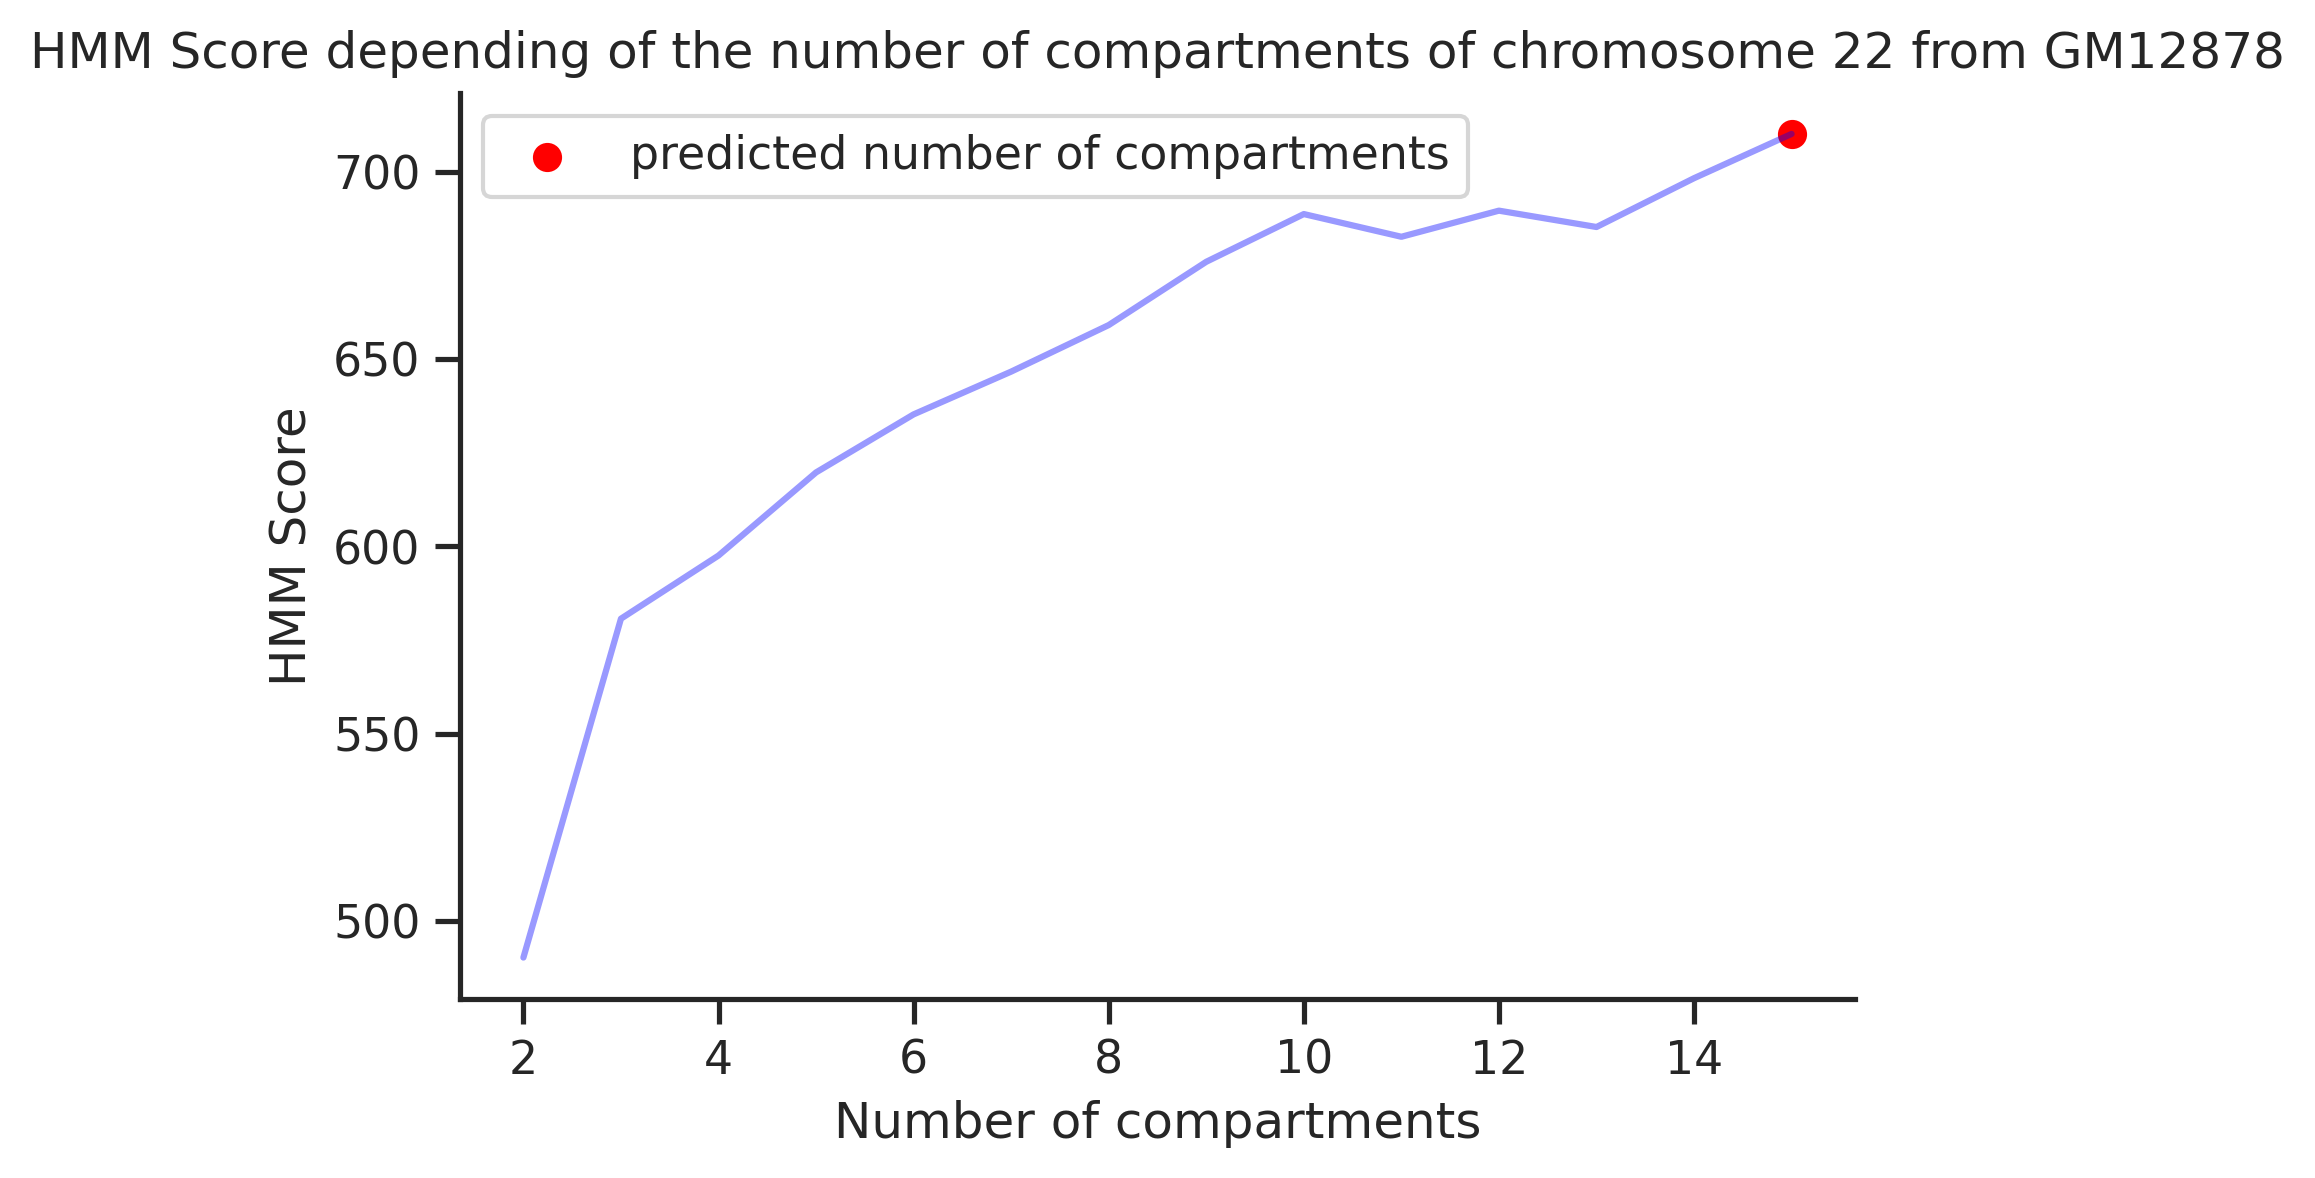

<Figure size 432x288 with 0 Axes>

In [20]:
data = scores
title = 'HMM Score depending of the number of compartments of chromosome '+nb+' from '+gene
HiCtoolbox.plotter(data, title, 'HMMScore', jupyter=True)

### HMM Barcode with eigenvector from correlation matrix

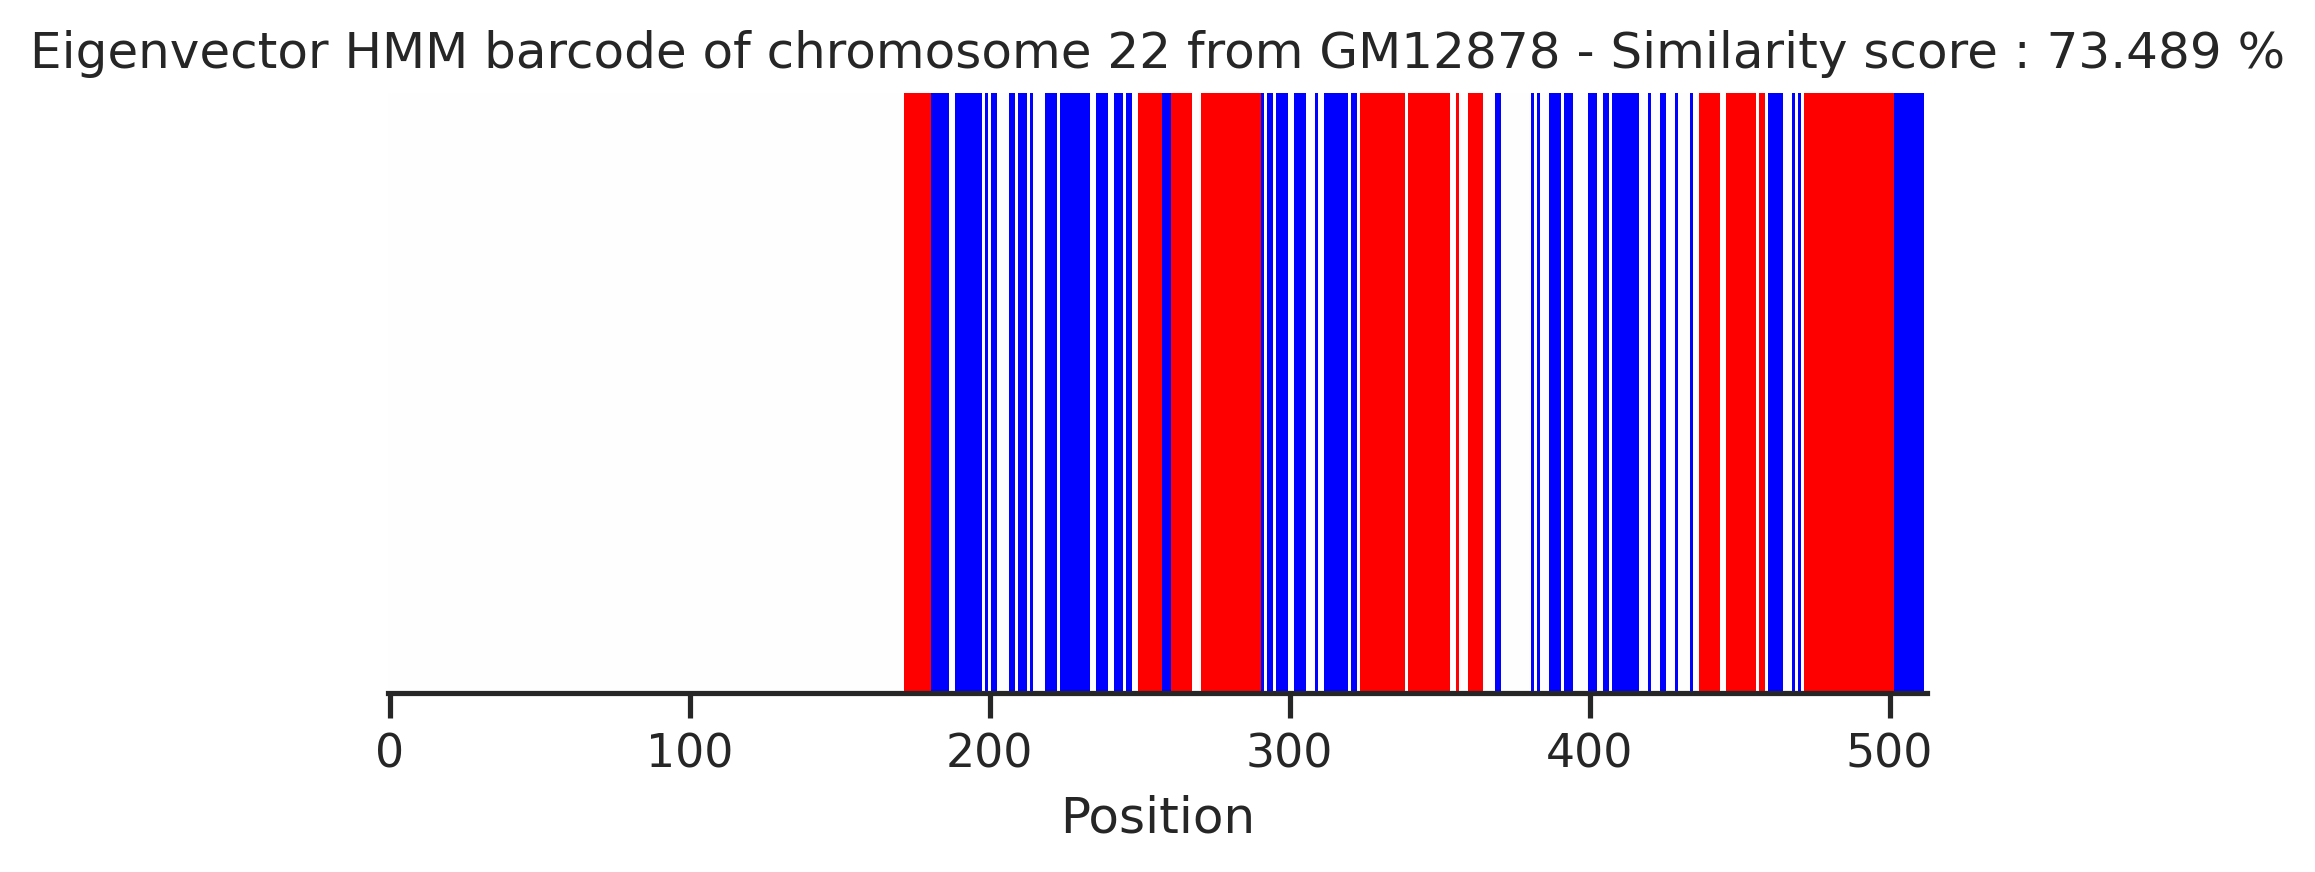

<Figure size 432x288 with 0 Axes>

In [21]:
data = labels[0]
data[data == 0.] = -1.
vector = HiCtoolbox.SVD(unfiltered_corr_map).reshape(-1, 1).flatten()
indexs = np.argwhere(vector == 0).flatten()
data = list(data)
for i in indexs:
    data.insert(i, 0.)
data = np.array(data)
if np.abs(np.sum(-data-AB))<np.abs(np.sum(data-AB)):
    data = -data
our_data = data
sim_score = HiCtoolbox.similarity_score(val_data, our_data)
title = 'Eigenvector HMM barcode of chromosome '+nb+' from '+gene+' - Similarity score : '+str(sim_score)+' %'
HiCtoolbox.plotter(data, title, 'Barcode', jupyter=True)

### Validation Barcode from Leopold Carron

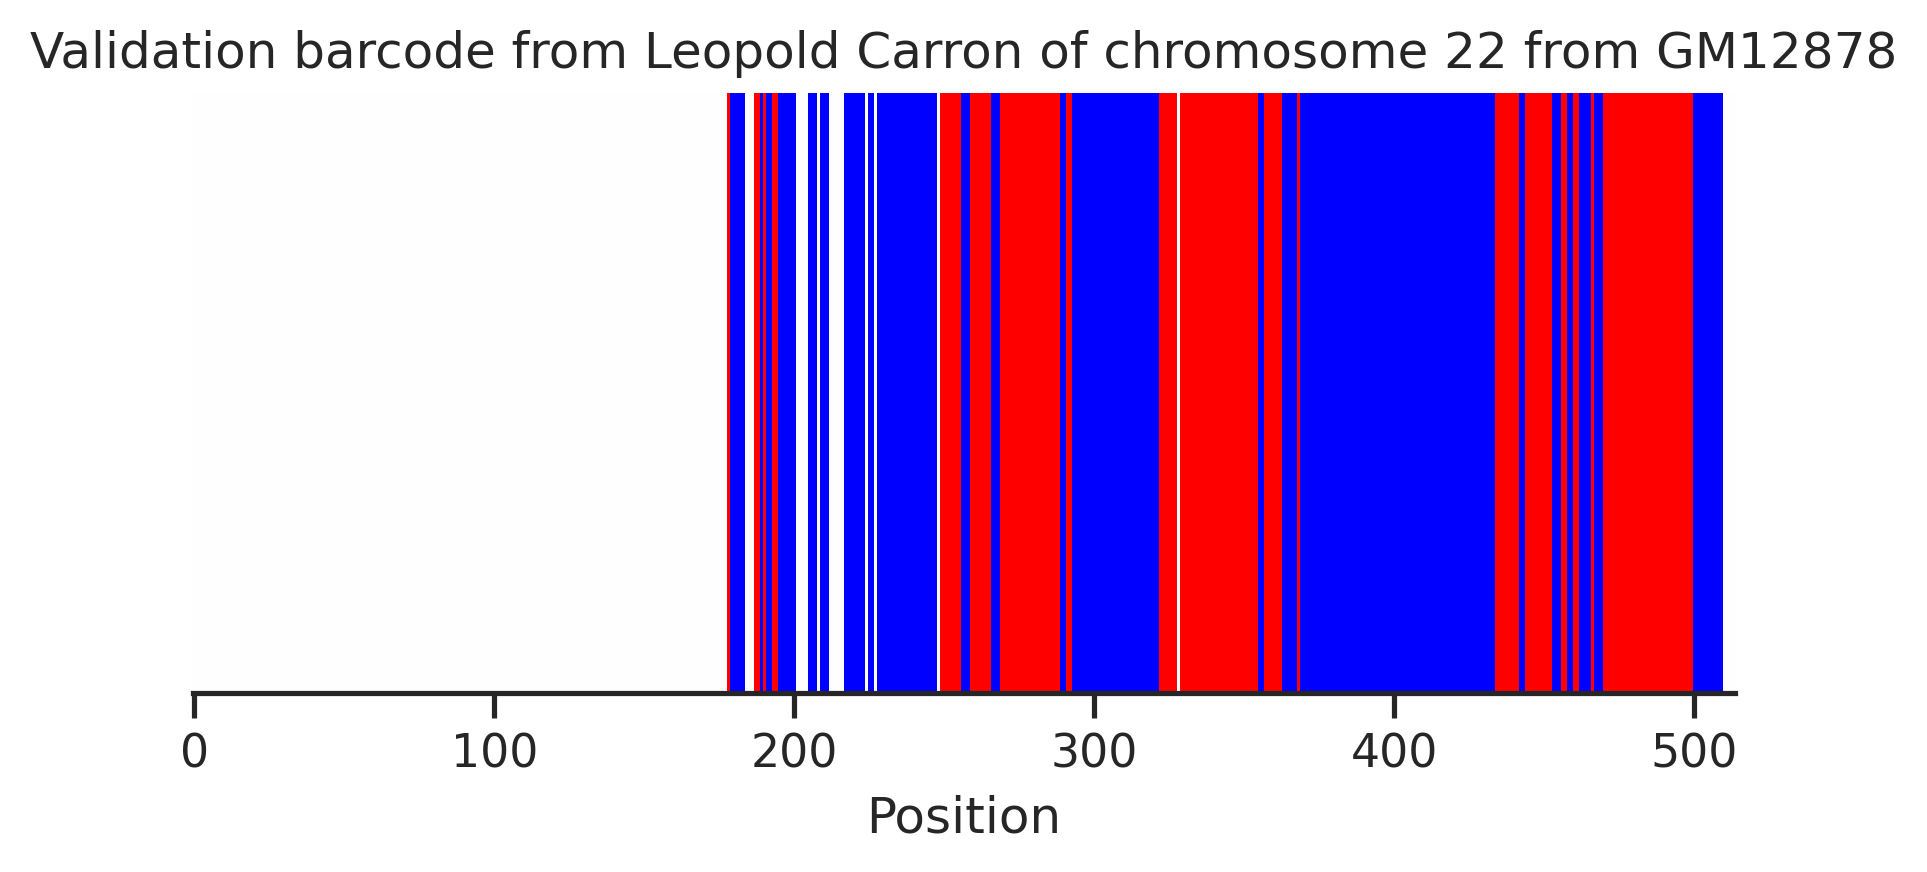

<Figure size 432x288 with 0 Axes>

In [22]:
title = 'Validation barcode from Leopold Carron of chromosome '+nb+' from '+gene
HiCtoolbox.plotter(val_data, title, 'Barcode', jupyter=True)

### Similarity Score with eigenvector from correlation matrix

In [23]:
print("Similarity score : "+str(sim_score)+' %')

Similarity score : 73.489 %


### Visualization of the results

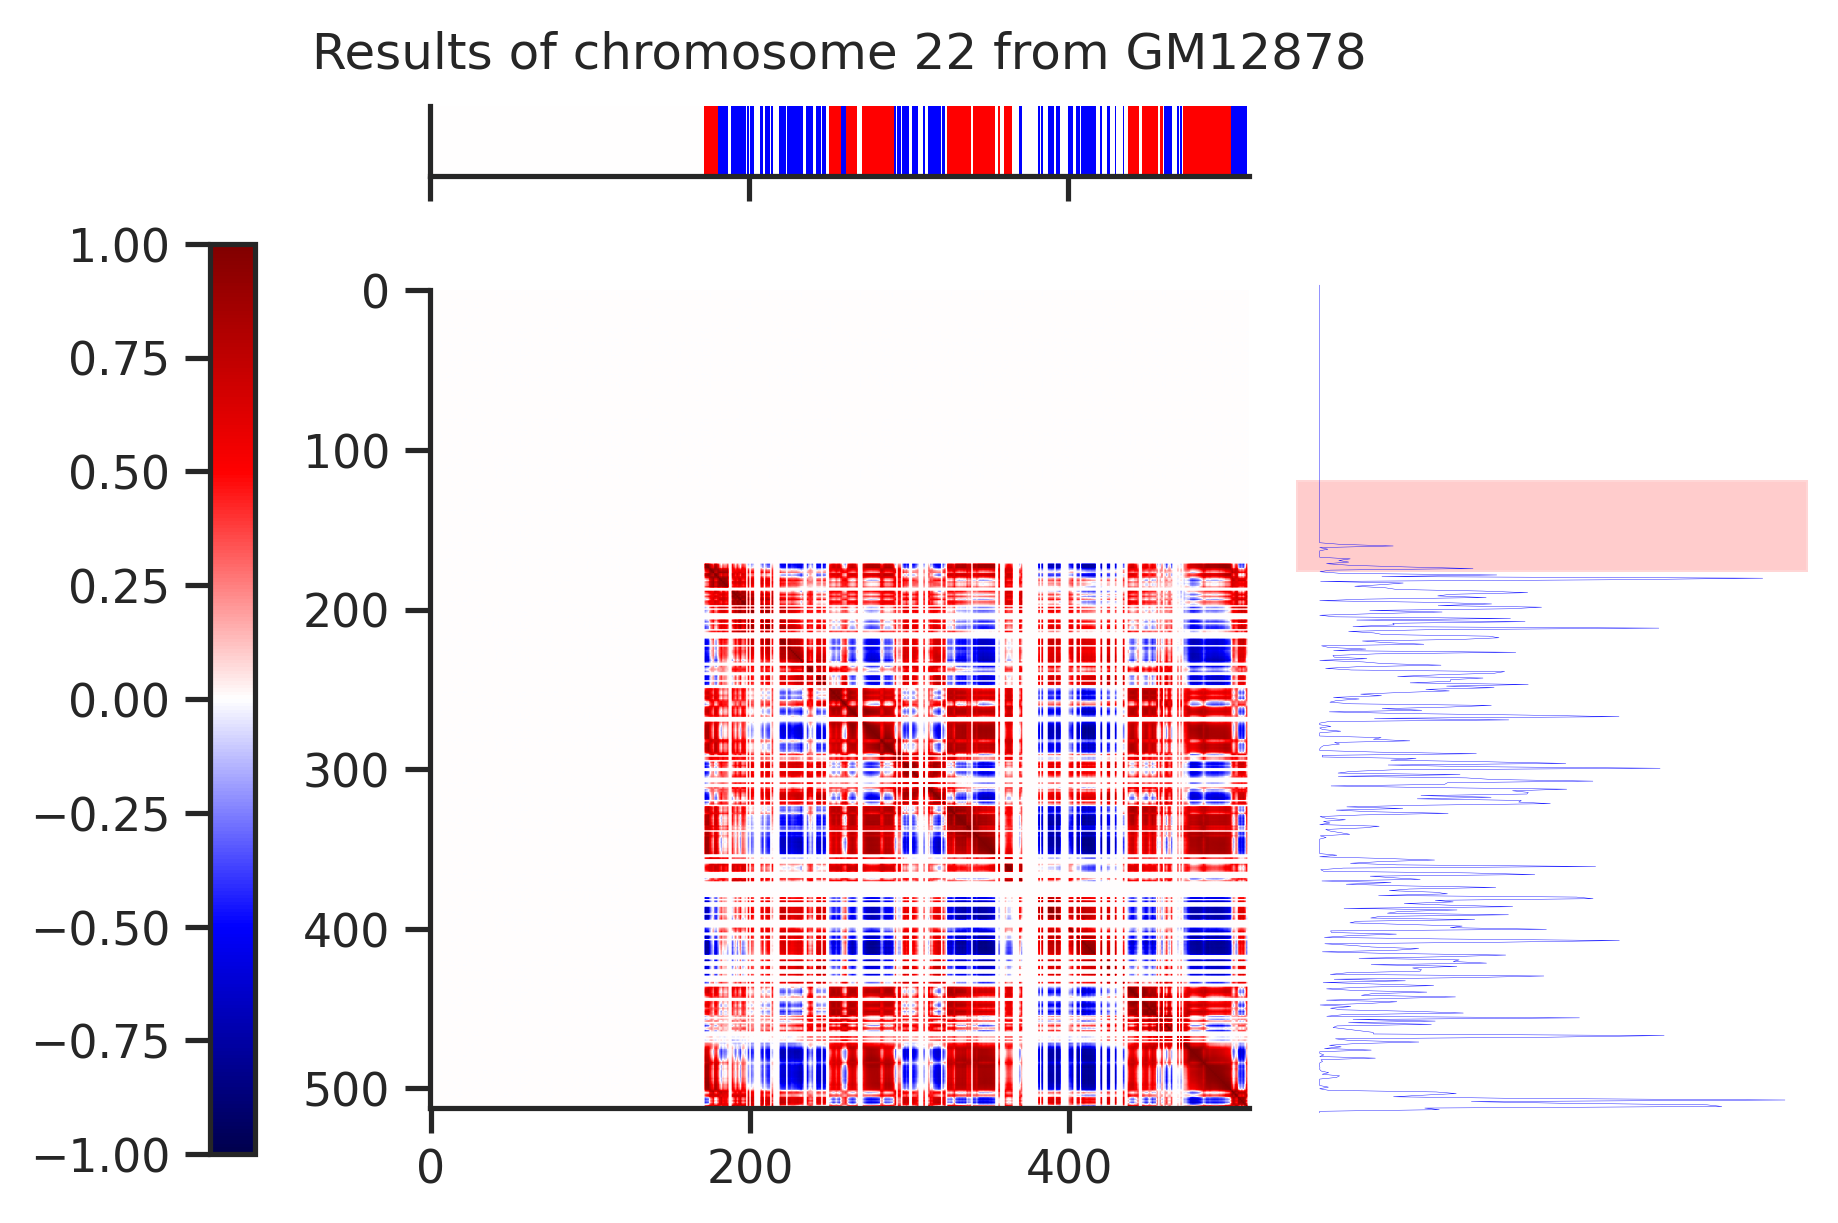

<Figure size 432x288 with 0 Axes>

In [24]:
data = [our_data, corr, density]
title = 'Results of chromosome '+nb+' from '+gene
HiCtoolbox.plotter(data, title, 'Visualization', jupyter=True, centro_start=centro_start, centro_end=centro_end)

## Method 2

### Gaussian HMM with expr/repr scores and epigenetic marks

In [25]:
marks = np.arange(1,16)
vector = HiCtoolbox.expr_repr_scoring(color_bins, marks, expr_repr_scores)
labels, scores = HiCtoolbox.multiplegaussianHMM(vector)
Preds_Epi = labels

Finding Compartments with HMM : 100%|███████████| 14/14 [00:10<00:00,  1.34it/s]


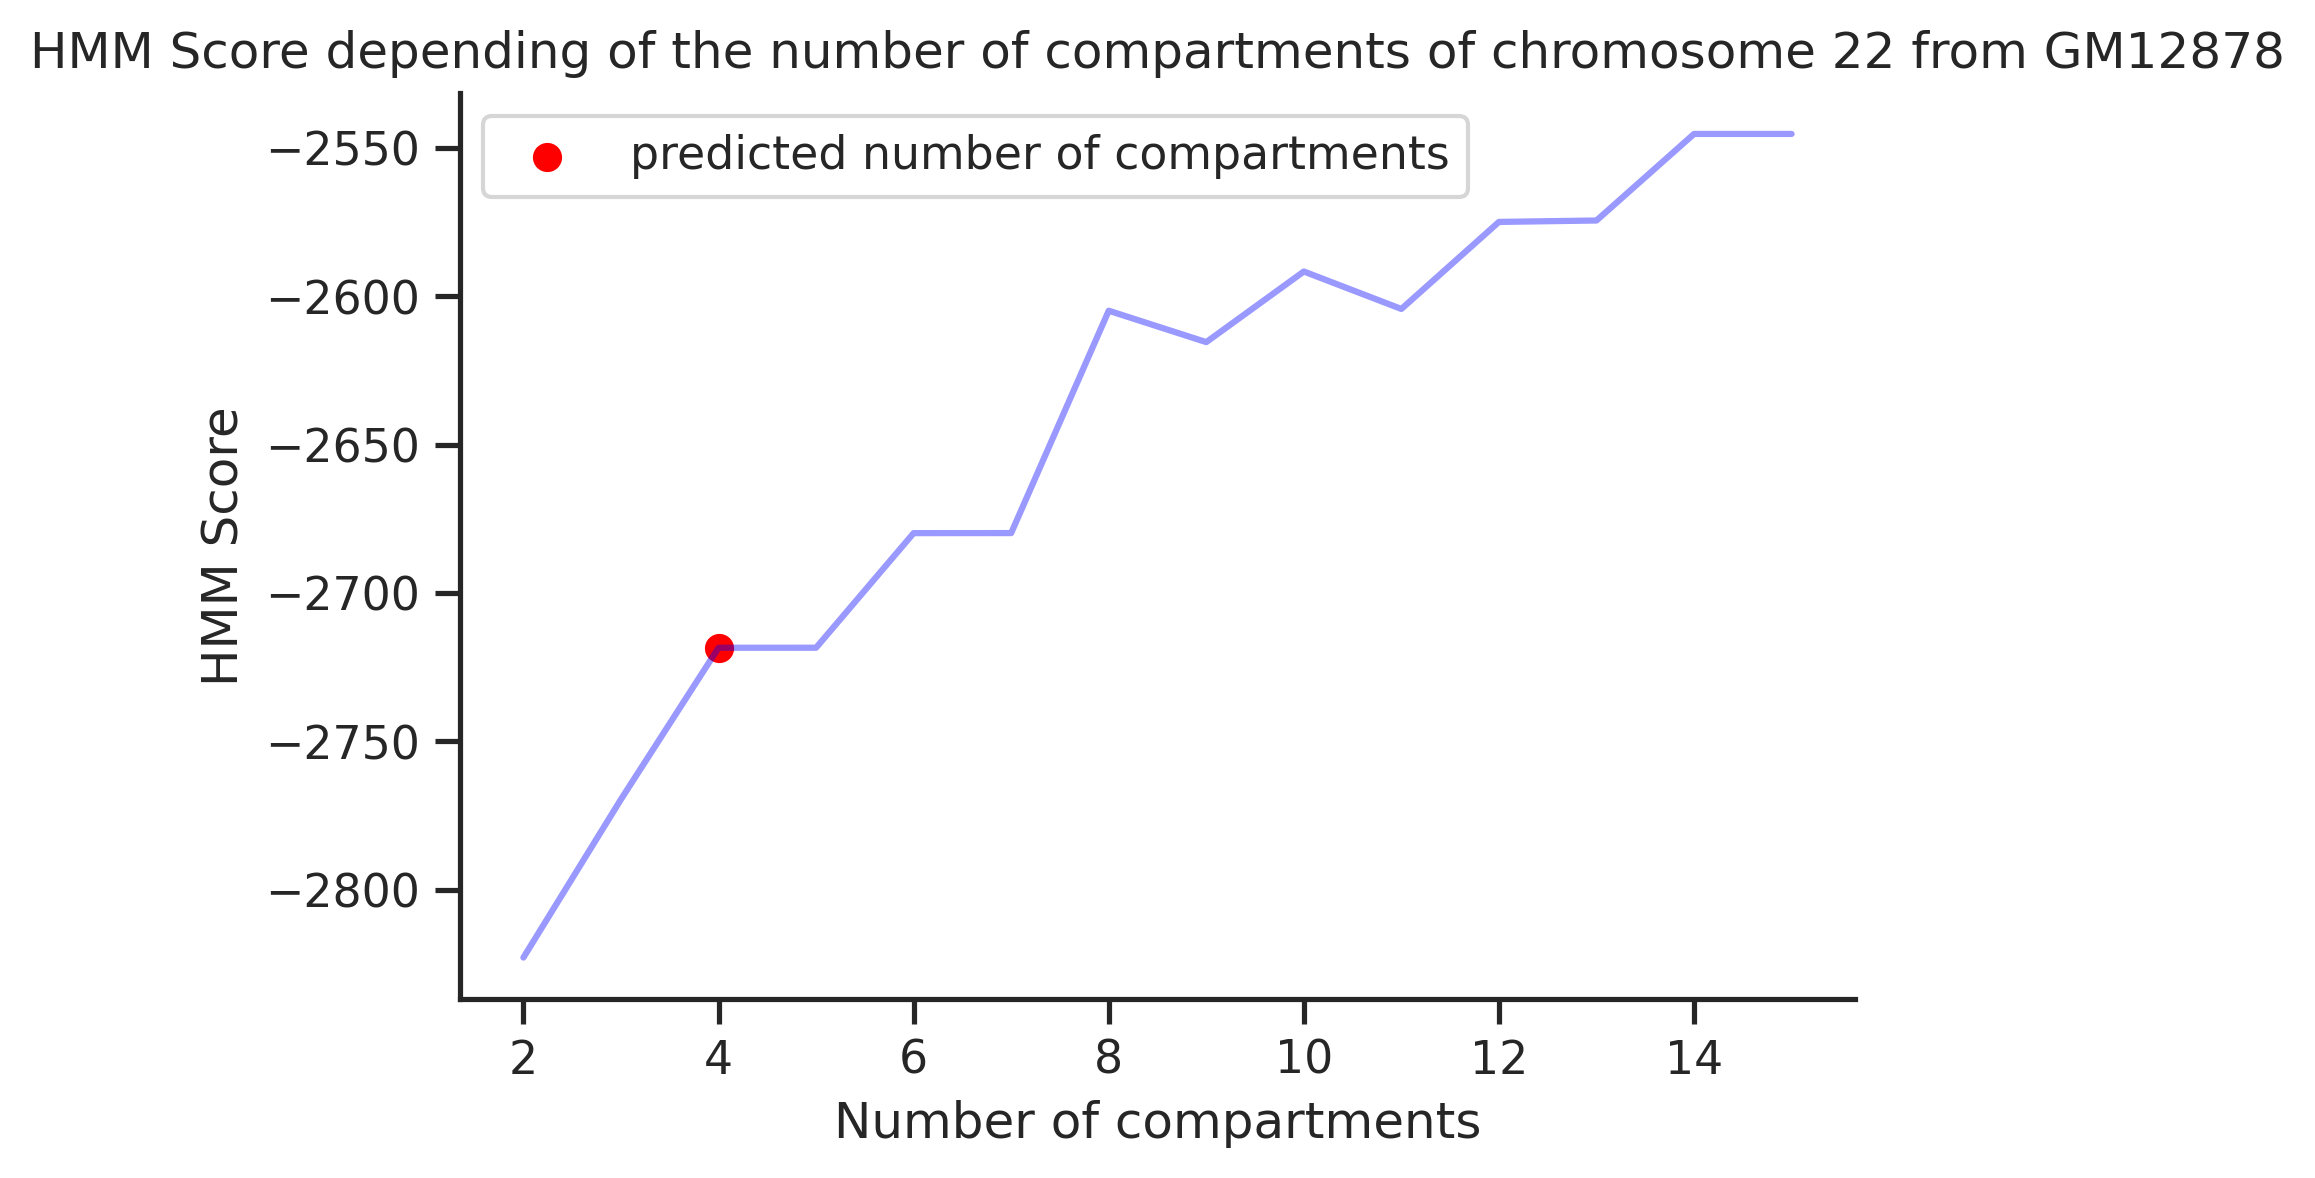

<Figure size 432x288 with 0 Axes>

In [26]:
data = scores
title = 'HMM Score depending of the number of compartments of chromosome '+nb+' from '+gene
HiCtoolbox.plotter(data, title, 'HMMScore', jupyter=True)

### HMM Barcode with expr/repr scores and epigenetic marks

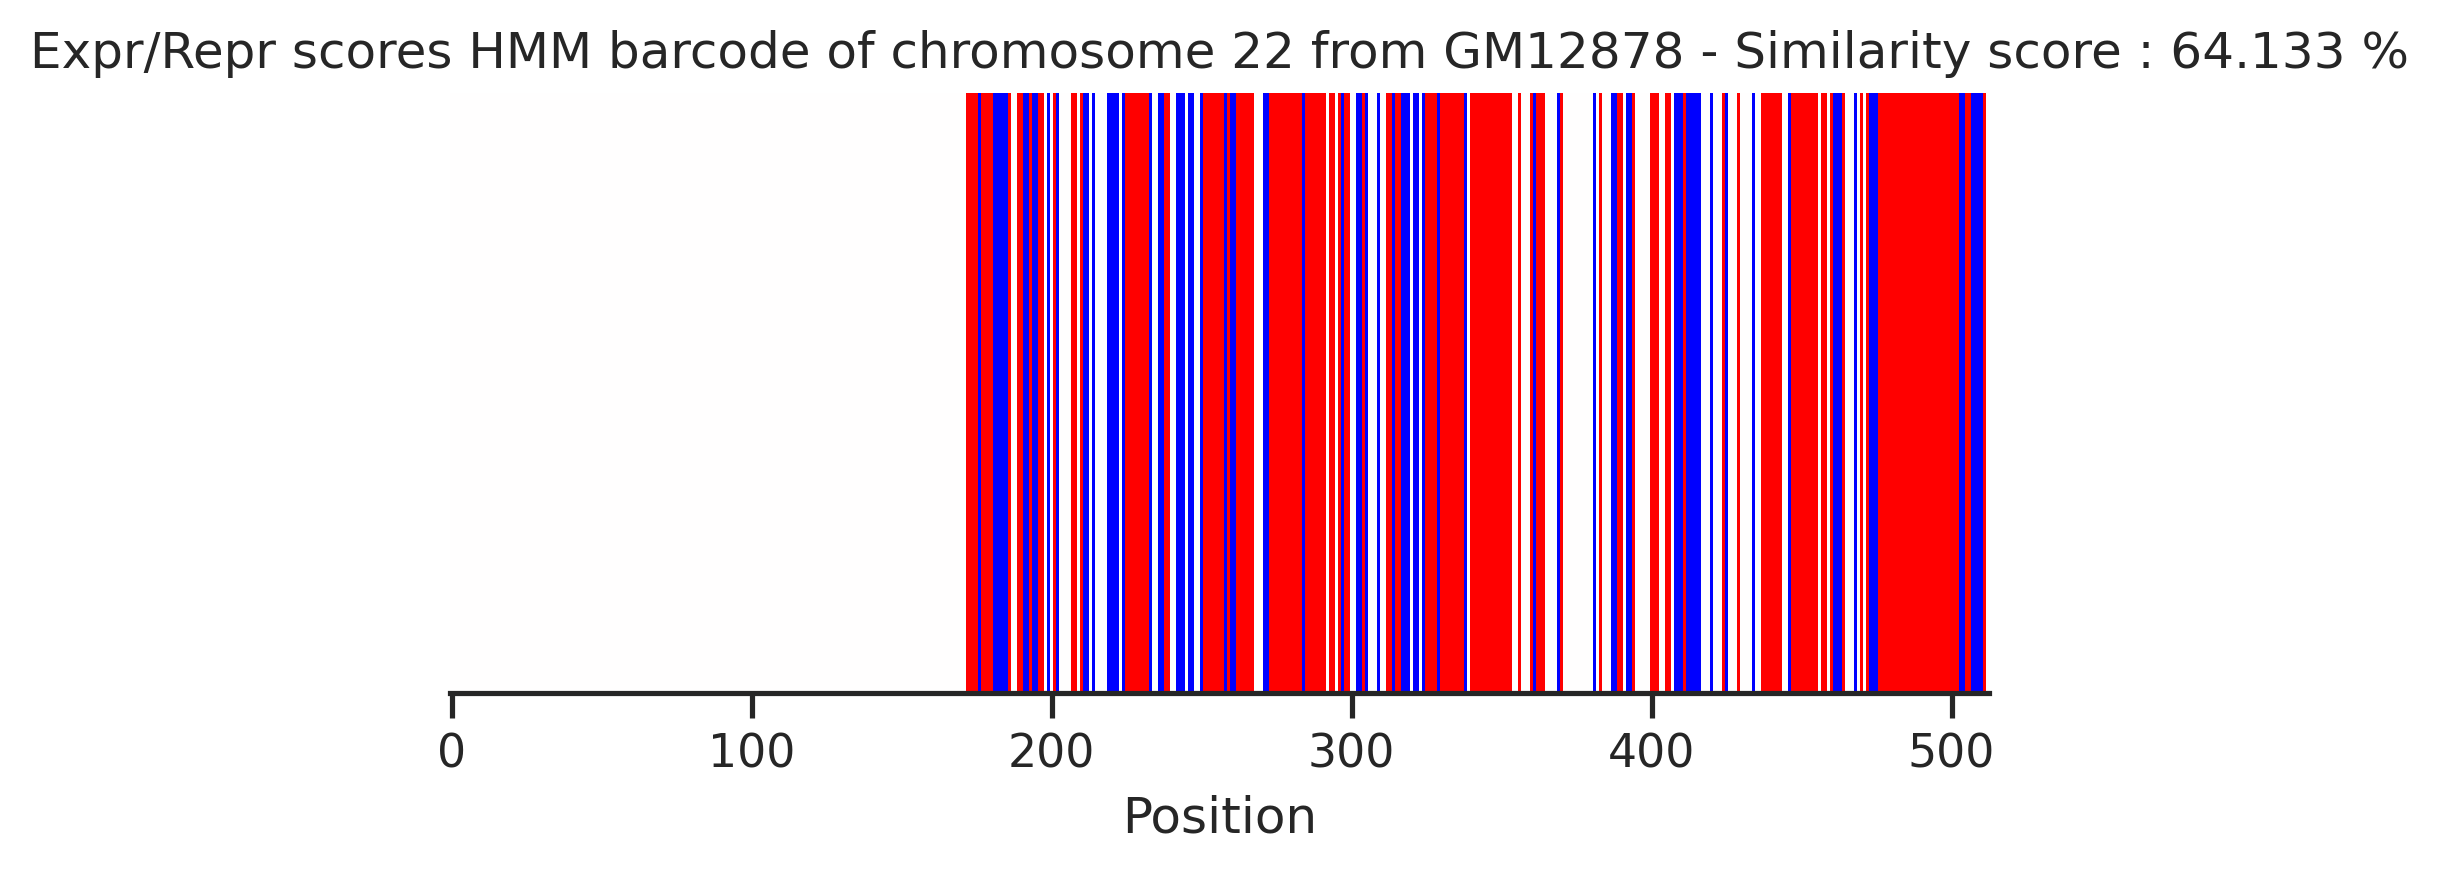

<Figure size 432x288 with 0 Axes>

In [27]:
data = labels[0]
data[data == 0.] = -1.
vector = HiCtoolbox.SVD(unfiltered_corr_map).reshape(-1, 1).flatten()
indexs = np.argwhere(vector == 0).flatten()
data = list(data)
for i in indexs:
    del data[i]
    data.insert(i, 0.)
data = np.array(data)
if np.abs(np.sum(-data-AB))<np.abs(np.sum(data-AB)):
    data = -data
our_data = data
sim_score = HiCtoolbox.similarity_score(val_data, our_data)
title = 'Expr/Repr scores HMM barcode of chromosome '+nb+' from '+gene+' - Similarity score : '+str(sim_score)+' %'
HiCtoolbox.plotter(data, title, 'Barcode', jupyter=True)

### Validation Barcode from Leopold Carron

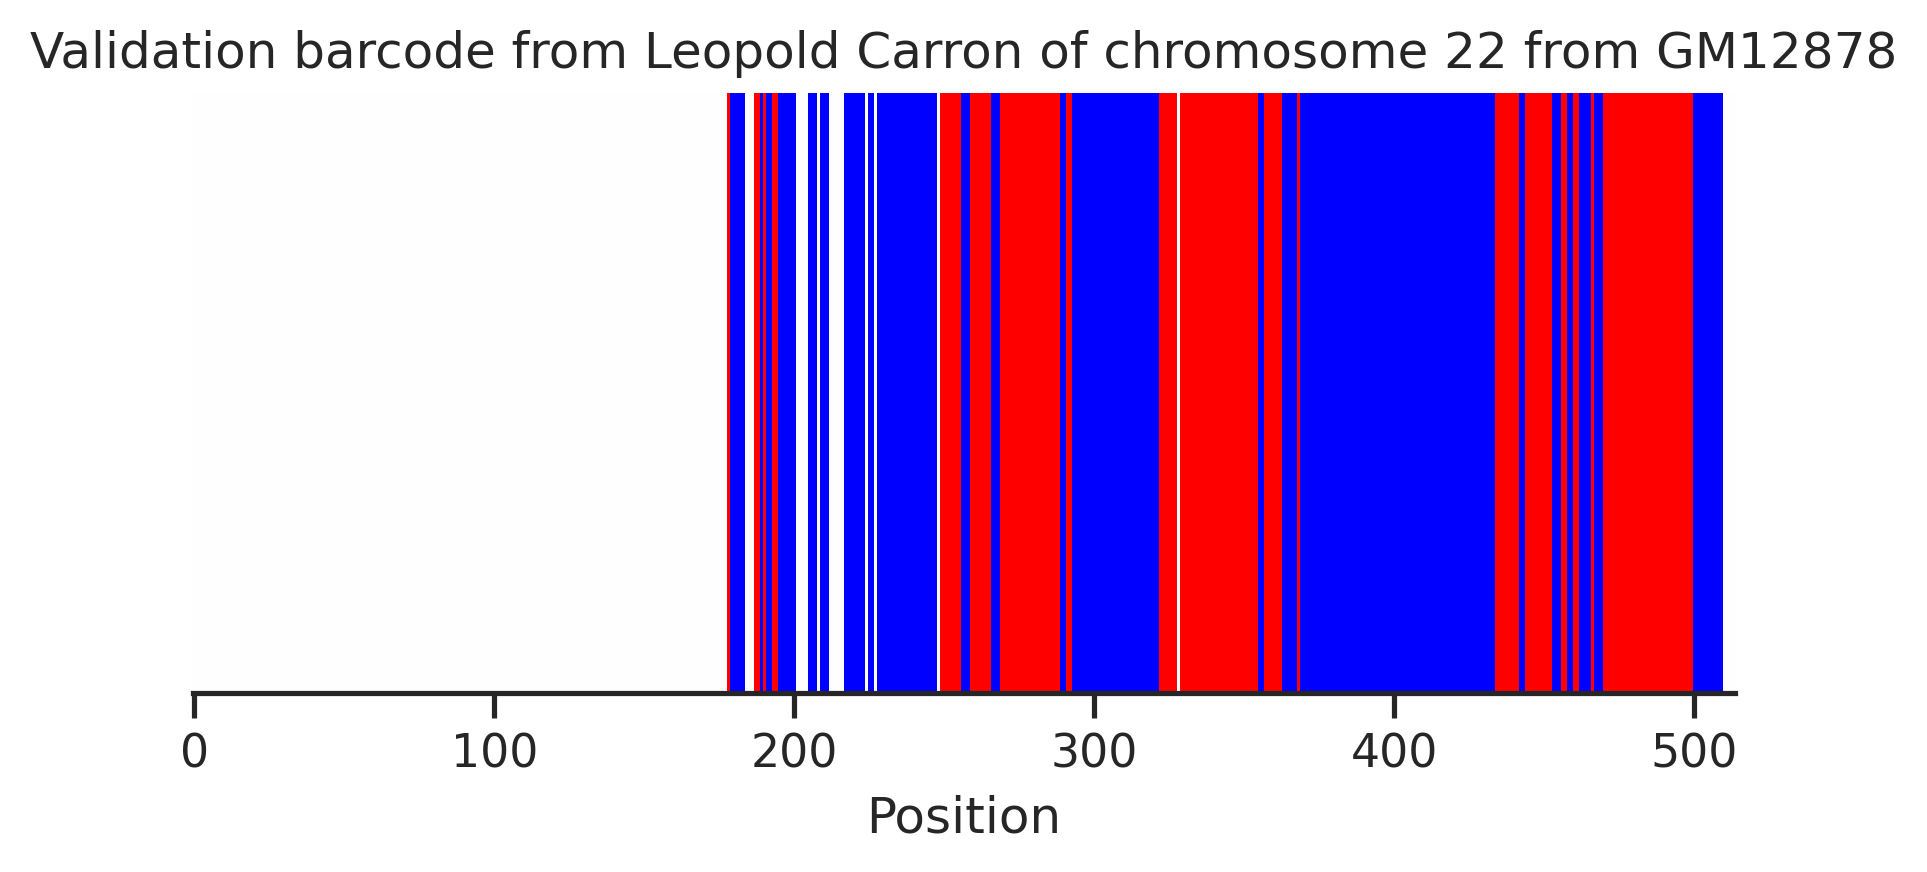

<Figure size 432x288 with 0 Axes>

In [28]:
title = 'Validation barcode from Leopold Carron of chromosome '+nb+' from '+gene
HiCtoolbox.plotter(val_data, title, 'Barcode', jupyter=True)

### Similarity Score with expr/repr scores and epigenetic marks

In [29]:
print("Similarity score : "+str(sim_score)+' %')

Similarity score : 64.133 %


### Visualization of the results

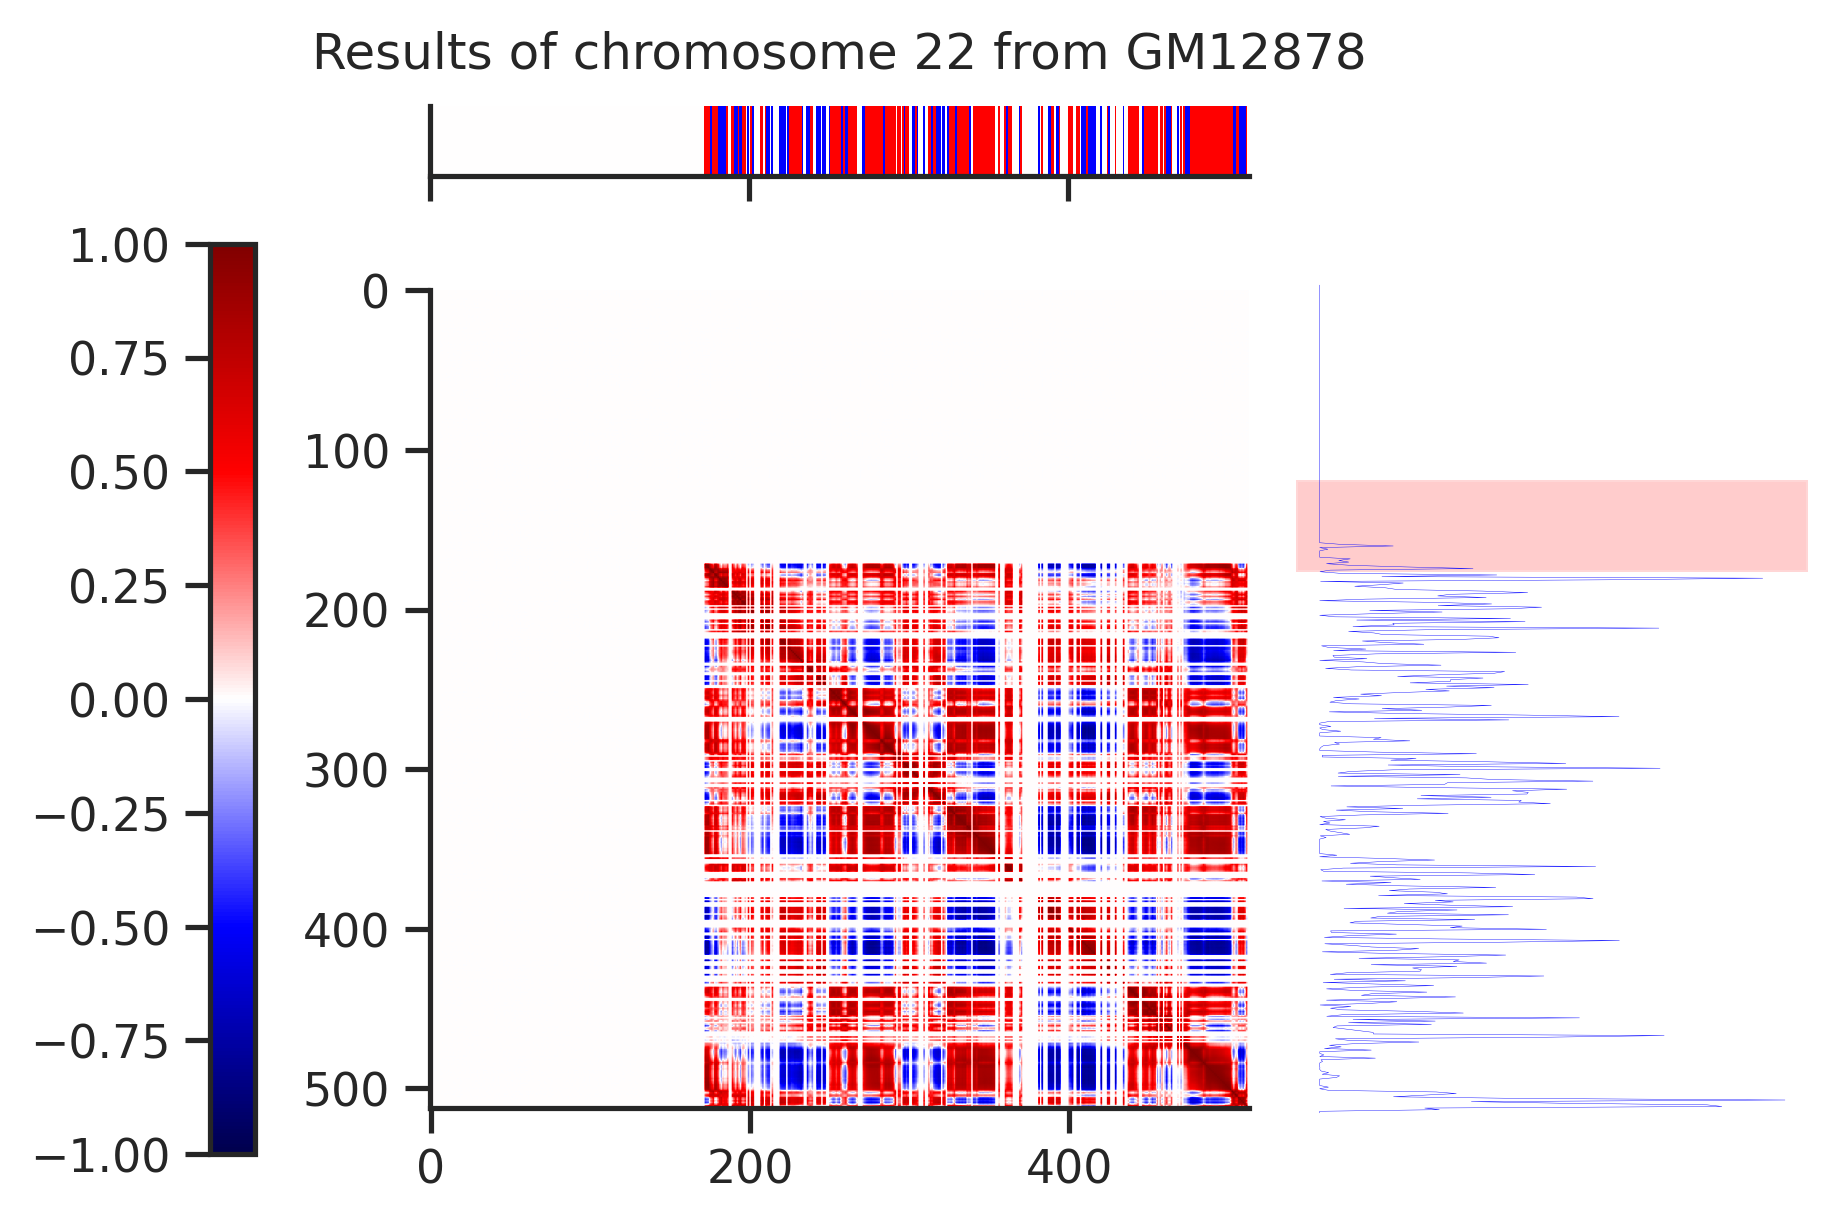

<Figure size 432x288 with 0 Axes>

In [30]:
data = [our_data, corr, density]
title = 'Results of chromosome '+nb+' from '+gene
HiCtoolbox.plotter(data, title, 'Visualization', jupyter=True, centro_start=centro_start, centro_end=centro_end)

### TODO: Autoencoder
- Probably not working with my gpu need to check why (Damien)
- Add it to the HiCtoolbox

In [31]:
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.cluster import KMeans
import os

#only for gpu
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

In [32]:
corr_map.shape[0]

247

In [33]:
encoding_dim = 2

In [34]:
input_ae = Input(shape=(corr_map.shape[0],))

encoded = Dense(np.floor(contact_map.shape[0]/3), activation='relu')(input_ae)
encoded = Dense(np.floor(contact_map.shape[0]/9), activation='relu')(encoded)
encoded = Dense(np.floor(contact_map.shape[0]/27), activation='relu')(encoded)

bottleneck  = Dense(encoding_dim, activation='relu')(encoded)  #Middle layer

decoded = Dense(np.floor(contact_map.shape[0]/27), activation='relu')(bottleneck)
decoded = Dense(np.floor(contact_map.shape[0]/9), activation='relu')(decoded)
decoded = Dense(np.floor(contact_map.shape[0]/3), activation='relu')(decoded)
decoded = Dense(contact_map.shape[0], activation='relu')(decoded)

2021-12-28 02:04:49.325013: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-28 02:04:49.355321: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-28 02:04:49.355897: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1070 with Max-Q Design computeCapability: 6.1
coreClock: 1.2655GHz coreCount: 16 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 238.66GiB/s
2021-12-28 02:04:49.355926: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-12-28 02:04:49.357069: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-12-28 02:04:49.357108: I tensorflow/stream_

In [35]:
autoencoder = Model(input_ae, decoded)
autoencoder.compile(optimizer= 'adam', loss='mean_squared_error')

In [36]:
#print(autoencoder.summary())

In [37]:
# Train the model
num_epochs = 200
batch_size = 512
history=autoencoder.fit(x=contact_map, y=contact_map,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    verbose=1)

2021-12-28 02:04:49.949918: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/200
1/1 [==============================] - 0s 431ms/step - loss: 1.0223
Epoch 2/200
1/1 [==============================] - 0s 2ms/step - loss: 1.0164
Epoch 3/200
1/1 [==============================] - 0s 3ms/step - loss: 1.0104
Epoch 4/200
1/1 [==============================] - 0s 4ms/step - loss: 1.0044
Epoch 5/200
1/1 [==============================] - 0s 3ms/step - loss: 0.9973
Epoch 6/200
1/1 [==============================] - 0s 3ms/step - loss: 0.9890
Epoch 7/200
1/1 [==============================] - 0s 3ms/step - loss: 0.9793
Epoch 8/200
1/1 [==============================] - 0s 2ms/step - loss: 0.9679
Epoch 9/200
1/1 [==============================] - 0s 2ms/step - loss: 0.9548
Epoch 10/200
1/1 [==============================] - 0s 4ms/step - loss: 0.9396
Epoch 11/200
1/1 [==============================] - 0s 3ms/step - loss: 0.9221
Epoch 12/200
1/1 [==============================] - 0s 4ms/step - loss: 0.9021
Epoch 13/200
1/1 [==============================] - 0s 2ms/

2021-12-28 02:04:50.258924: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Epoch 17/200
1/1 [==============================] - 0s 3ms/step - loss: 0.7565
Epoch 18/200
1/1 [==============================] - 0s 4ms/step - loss: 0.7181
Epoch 19/200
1/1 [==============================] - 0s 2ms/step - loss: 0.6775
Epoch 20/200
1/1 [==============================] - 0s 4ms/step - loss: 0.6356
Epoch 21/200
1/1 [==============================] - 0s 4ms/step - loss: 0.5942
Epoch 22/200
1/1 [==============================] - 0s 3ms/step - loss: 0.5558
Epoch 23/200
1/1 [==============================] - 0s 3ms/step - loss: 0.5240
Epoch 24/200
1/1 [==============================] - 0s 5ms/step - loss: 0.5029
Epoch 25/200
1/1 [==============================] - 0s 2ms/step - loss: 0.4965
Epoch 26/200
1/1 [==============================] - 0s 2ms/step - loss: 0.5052
Epoch 27/200
1/1 [==============================] - 0s 3ms/step - loss: 0.5220
Epoch 28/200
1/1 [==============================] - 0s 2ms/step - loss: 0.5347
Epoch 29/200
1/1 [==============================] - 

1/1 [==============================] - 0s 3ms/step - loss: 0.4431
Epoch 121/200
1/1 [==============================] - 0s 3ms/step - loss: 0.4431
Epoch 122/200
1/1 [==============================] - 0s 3ms/step - loss: 0.4431
Epoch 123/200
1/1 [==============================] - 0s 3ms/step - loss: 0.4431
Epoch 124/200
1/1 [==============================] - 0s 2ms/step - loss: 0.4431
Epoch 125/200
1/1 [==============================] - 0s 3ms/step - loss: 0.4431
Epoch 126/200
1/1 [==============================] - 0s 4ms/step - loss: 0.4431
Epoch 127/200
1/1 [==============================] - 0s 2ms/step - loss: 0.4431
Epoch 128/200
1/1 [==============================] - 0s 2ms/step - loss: 0.4431
Epoch 129/200
1/1 [==============================] - 0s 2ms/step - loss: 0.4431
Epoch 130/200
1/1 [==============================] - 0s 3ms/step - loss: 0.4431
Epoch 131/200
1/1 [==============================] - 0s 2ms/step - loss: 0.4431
Epoch 132/200
1/1 [==============================] - 0

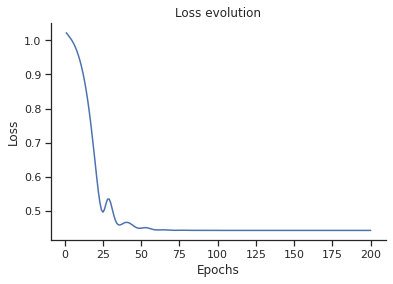

In [38]:
#train evolution
plt.plot(np.arange(1,num_epochs+1),history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title ('Loss evolution')
plt.show()

In [39]:
# need encoder
encoder = Model(input_ae, bottleneck)
encoded_map = encoder.predict(contact_map)
encoded_map.shape

(247, 2)

Text(0.5, 1.0, 'Autoencodeur - clusters= 2')

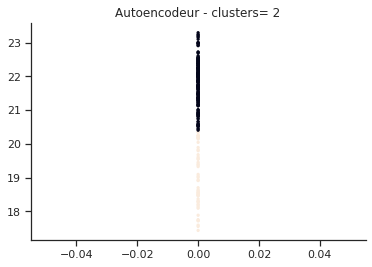

In [40]:
kmeans = KMeans(n_clusters = 2).fit_predict(encoded_map)
plt.scatter(encoded_map[:, 0], encoded_map[:, 1], c = kmeans, s = 5) 
plt.title("Autoencodeur - clusters= 2")

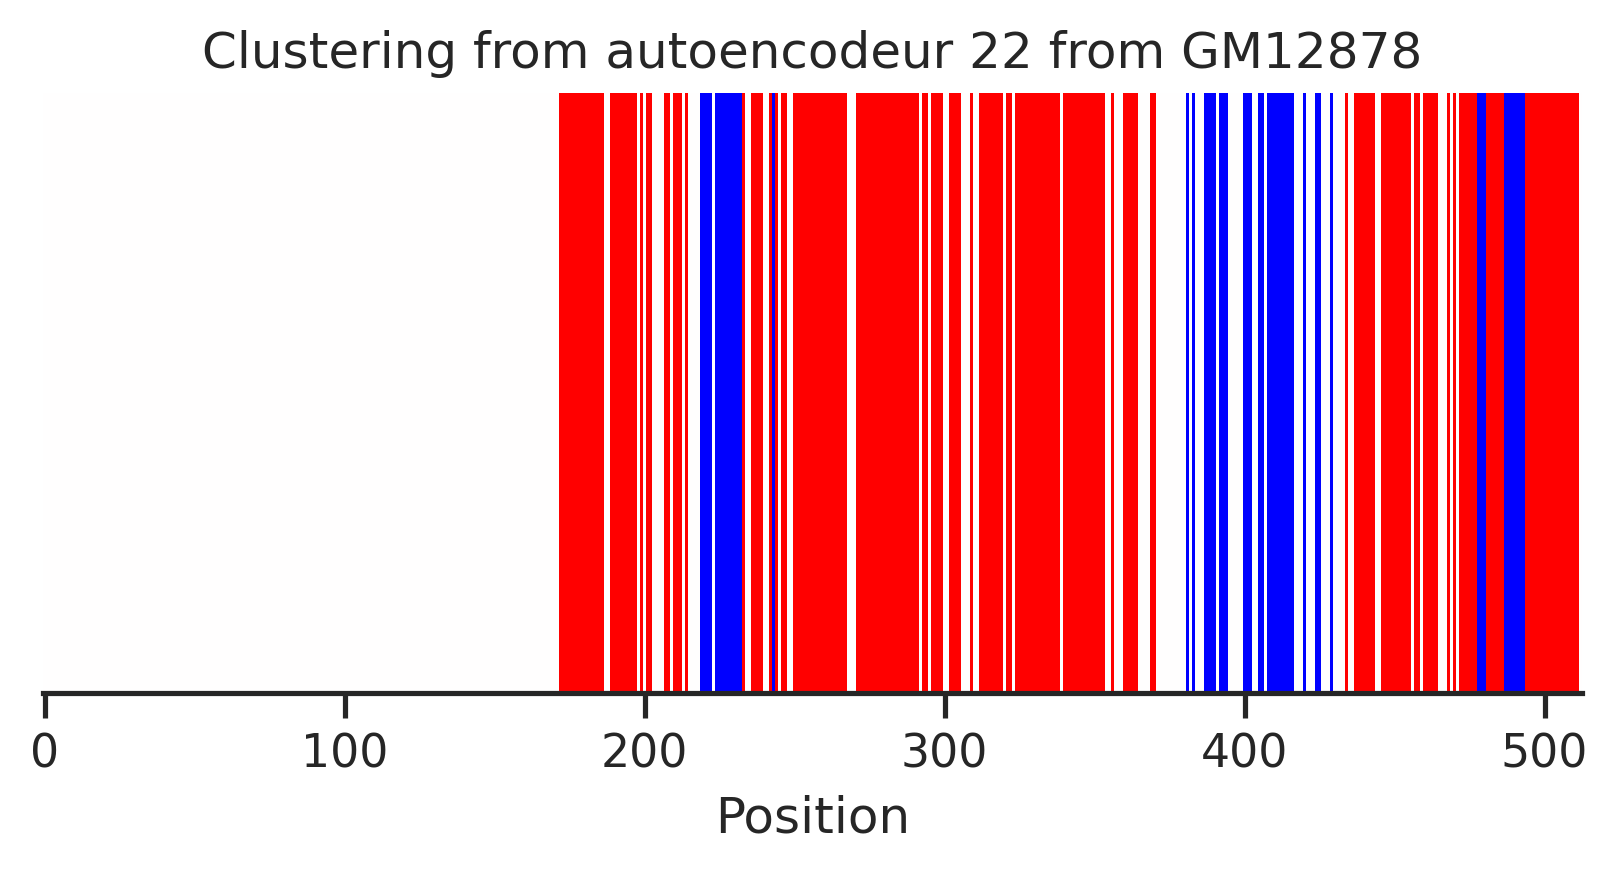

<Figure size 432x288 with 0 Axes>

In [41]:
data = kmeans
data[data == 0.] = -1.
eigenvector = HiCtoolbox.SVD(unfiltered_corr_map).reshape(-1, 1).flatten()
indexs = np.argwhere(eigenvector == 0).flatten()
data = list(data)
for i in indexs:
    data.insert(i, 0.)
data = -np.array(data)
our_data = data
title = 'Clustering from autoencodeur '+nb+' from '+gene
HiCtoolbox.plotter(data, title, 'Barcode', jupyter=True)

In [42]:
cnt = 0
for i in range(np.shape(data)[0]):
    if val_data[i] == our_data[i]:
        cnt += 1

similarity = cnt/np.shape(data)[0] * 100
print(str(round(similarity, 3))+' %')

62.573 %


### TODO: Similarity tools
- Make it work with the HiCtoolbox
- Add it to the HiCtoolbox

In [43]:
from All_possi import *

#Similarity tools

#/!\ if nb_methods=1 -> we compare 2 methods
#nb_scenarios = (nb_cpt^(nb_cpt+nb_methods))^2
best_scenarios = []
similarities = []
for n in range(2,16):
    nb_methods = 1
    nb_cpt = n
    All_possi = get_All_possiblesPaths(nb_cpt, nb_methods)
    All_Preds = [Preds_Contact[nb_cpt-2],Preds_Epi[nb_cpt-2]]
    All_tests = []
    
    for scenario in All_possi:
        similarity = HiCtoolbox.calculateSimilarity(scenario, All_Preds, nb_cpt, nb_methods)
        All_tests.append([scenario, similarity])
        best_scenario, similarity = HiCtoolbox.find_bestScenario(All_tests, nb_cpt)
    best_scenarios.append(best_scenario)
    similarities.append(similarity)
    
print('Best Scenario : ', best_scenarios)
#scenario : ([labelcptPred1, labelcptPred2, ...], ...)
print('Similarity : ', similarities)
print('#####')
HiCtoolbox.plotter(similarities, 'Similarity_Score_plot_'+chromosome_name+'.pdf', 'HMMScore')

KeyError: (0, 0)